# MSBA7021 Group 40 Project Codebase
## Deep Option Hedging using Risk-Averse Contextual Bandit Learning

## Env Setup

In [684]:
import numpy as np
import pandas as pd
import random

from scipy.stats import norm, invgamma
import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

from GPyOpt.methods import BayesianOptimization

import torch
from torch import nn

from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 15,
                     'figure.figsize': [16,8]})
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [687]:
torch.__version__

'1.8.0+cu111'

PLEASE NOTE that most of our learning agents are inherently stochastic in terms of initialization, batch/parameter sampling, neural network gradient descent, etc., and so is the market simulation. That said, users should be able to reproduce the results in a highly similar manner, though not exactly the same:-D

## Problem Definition

### Specifications for Market Simulation

$\textrm{StockPrice ~ GBM}$
$$
\begin{aligned}
f_{S_{t}}(s;\mu ,\sigma ,t) &= {\frac {1}{\sqrt {2\pi }}}\,{\frac {1}{s\sigma {\sqrt {t}}}}\,\exp \left(-{\frac {\left(\ln s-\ln S_{0}-\left(\mu -{\frac {1}{2}}\sigma ^{2}\right)t\right)^{2}}{2\sigma ^{2}t}}\right) \\
S_{t} &= S_{0}\exp \left(\left(\mu -{\frac {\sigma ^{2}}{2}}\right)t+\sigma W_{t}\right), \hspace{2mm} W_{t}=W_{t}-W_{0}\sim N(0,t)
\end{aligned}
$$

$\textrm{OptionPrice ~ BSM}$
$$
{\displaystyle {\begin{aligned}C(S_{t},t)&=N(d_{1})S_{t}-N(d_{2})Ke^{-r(T-t)}\\d_{1}&={\frac {1}{\sigma {\sqrt {T-t}}}}\left[\ln \left({\frac {S_{t}}{K}}\right)+\left(r+{\frac {\sigma ^{2}}{2}}\right)(T-t)\right]\\d_{2}&=d_{1}-\sigma {\sqrt {T-t}}\\\end{aligned}}}
$$

In [3]:
def GBM(num_episodes, So=1.0, dt=1, T=60, mu=0.01, sigma=0.3):
    """Geometric Brownian Motion (GBM) for stock price
    
    Parameter Definitions
    
    So    :   initial stock price
    dt    :   time increment
    T     :   length of the time horizon (time span)
    N     :   number of time steps in the time horizon -> T/dt
    t     :   array for time steps in the time horizon -> [1, 2, 3, .. , N]
    mu    :   mean in GBM
    sigma :   standard deviation in GBM
    b     :   array for Brownian increments
    W     :   array for Wiener process
    
    """

    # Parameter assignments
    N = T / dt
    t = np.arange(dt, T+1, dt)

    mu = 0.01
    sigma = 0.3

    b = {str(episode): np.random.normal(0, np.sqrt(dt), int(N)) for episode in range(1, num_episodes + 1)}
    W = {str(episode): b[str(episode)].cumsum() for episode in range(1, num_episodes + 1)}


    # Calculate drift and diffusion components
    drift = (mu - sigma ** 2 / 2) * t
    diffusion = {str(episode): sigma * W[str(episode)] for episode in range(1, num_episodes + 1)}

    # Calculate GBM
    S = np.array([So * np.exp(drift + diffusion[str(episode)]) for episode in range(1, num_episodes + 1)])
    S = np.hstack((np.array([[So] for episode in range(num_episodes)]), S))  # add So to the beginning
    
    return S

In [4]:
def BSM(stock, K=1.0, r=0.01, sigma=0.3, T=60):
    """Black-Scholes Model (BSM) for option price
    
    Parameter Definitions
    
    stock :    numpy 2darray of stock price simulation
    C     :    call option price
    S     :    stock price at time t, underlying price
    K     :    strike price
    r     :    continuously compounded risk-free interest rate
    t     :    time step
    T     :    length of the time horizon (time span)
    sigma :    volatility of the asset
    d1    :    conditional probability 
    d2    :    the probability that the option will expire in the money
    
    """
    from scipy.stats import norm
    
    option_price_all = []
    for episode in range(stock.shape[0]):
        ls_option_price = []
        for t in range(stock.shape[1]):
            S = stock[episode][t]
            ttm = T - t
            if ttm == 0:
                C = max(0, S - K)
                ls_option_price.append(C)
                continue
            d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * ttm) / (sigma * np.sqrt(ttm))
            d2 = d1 - sigma * np.sqrt(ttm)
            C = norm.cdf(d1) * S - norm.cdf(d2) * K * np.exp(-r * ttm)
            ls_option_price.append(C)
        option_price_all.append(ls_option_price)
    option_price = np.array(option_price_all)
    
    return option_price

In [5]:
def dataGen(num_episodes, So=1.0, dt=1, T=60, mu=0.01, sigma=0.3, K=1.0, r=0.01):
    """Data generator for simulating market behavior (stock/option prices)
    
    Parameter Definitions
    
    So    :   initial stock price
    dt    :   time increment
    T     :   length of the time horizon (time span)
    mu    :   mean in GBM
    sigma :   standard deviation in GBM
    K     :   strike price
    r     :   continuously compounded risk-free interest rate
    
    """
    stock_price = GBM(num_episodes, So=So, dt=dt, T=T, mu=mu, sigma=sigma)
    option_price = BSM(stock_price, K=K, r=r, sigma=sigma, T=T)
    
    assert stock_price.shape == option_price.shape
    
    return stock_price, option_price

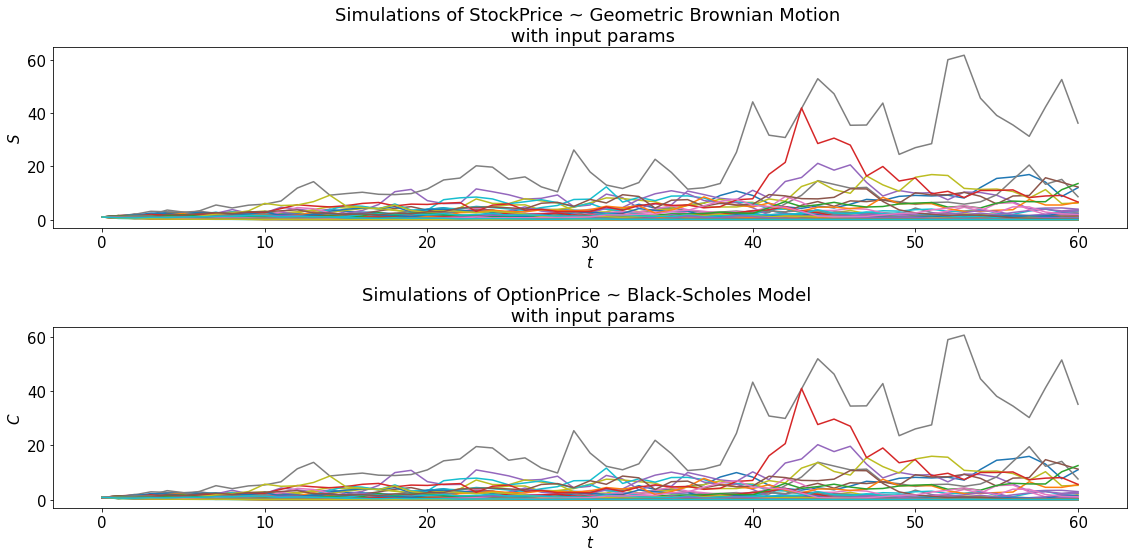

In [8]:
# test dataGen func.
S, C = dataGen(100)

# viz simulated stock/option prices
plt.subplot(211)
plt.plot(S.T)
plt.xlabel("$t$")
plt.ylabel("$S$")
plt.title(
    f"Simulations of StockPrice ~ Geometric Brownian Motion \n with input params"
)

plt.subplot(212)
plt.plot(C.T)
plt.xlabel("$t$")
plt.ylabel("$C$")
plt.title(
    f"Simulations of OptionPrice ~ Black-Scholes Model \n with input params"
)

plt.tight_layout()
plt.show()

### Objective Function

$$
\begin{aligned}
\textrm{Utility/Reward:} \hspace{2mm} u_t = & k \cdot E[-\Delta C_{t+1} + n_{t+1}\Delta S_{t+1} + Cost(n_t,n_{t+1},S_t) \mid F_t] \\
& - V[-\Delta C_{t+1} + n_{t+1}\Delta S_{t+1} + Cost(n_t,n_{t+1},S_t) \mid F_t] \\
\textrm{Transaction Cost:} \hspace{2mm} Cost(n_t,n_{t+1},S_t) = & -\eta \cdot S_t \cdot |n_{t+1} - n_t| \\
\textrm{Scalar Gauging Factor} = & \hspace{2mm} 100 \\
\textrm{Cut-Off} = & \hspace{2mm} 2
\end{aligned}
$$

$$
\begin{aligned}
\textrm{Value of Hedging Portfolio:} \hspace{2mm} \Pi_t = & n_tS_t + B_t \quad \textrm{( self-financing )} \\
\Delta\Pi_{t+1} = & n_{t+1}S_{t+1} + \Delta B_{t+1} - n_tS_t + Cost(n_t,n_{t+1},S_t) \\
= & n_{t+1} \Delta S_{t+1} + Cost(n_t,n_{t+1},S_t)
\end{aligned}
$$

## Hedging Model Impl.

### Data Buffer

In [9]:
# Define a data buffer for contextual bandit
class ContextActionRewardDataset():
    """Dataset class to store context-action-reward observations
    
    Observations/actions are stored in attributes: _contexts, _rewards, actions.
    The buffer is able to append new data and sample random minibatches.
    
    Args:
    _context_dim: dimension of the contexts
    _num_actions: number of arms for the multi-armed bandit
    buffer_size : size of buffer for training (only last buffer_size will be returned as minibatch;
                  if buffer_size = -1, all data will be used)
    intercept   : if True, it adds a constant (1.0) dimension to each context X at the end
    
    """
    
    def __init__(self, context_dim, num_actions, buffer_size=-1, intercept=False):
        self._context_dim = context_dim
        self._num_actions = num_actions
        self._contexts = None
        self._scaled_contexts = None
        self._rewards = None
        self._actions = []
        self.buffer_size = buffer_size
        self.intercept = intercept

    def add(self, context, action, reward):
        """Adds a new triplet (context, action, reward) to the dataset.
        The reward for the actions that weren't played is assumed to be zero.

        Args:
          context: d-dimensional vector with the context
          action : int between 0 and k-1 representing the chosen arm
          reward : reward for the (context, action)

        """

        if self.intercept:
            c = np.array(context[:])   # 1darray
            c = np.append(c, 1.0).reshape((1, self.context_dim + 1))   # 2darray
        else:
            c = np.array(context[:]).reshape((1, self.context_dim))

        if self.contexts is None:
            self.contexts = c
        else:
            self.contexts = np.vstack((self.contexts, c))

        r = np.zeros((1, self.num_actions))
        r[0, action] = reward
        if self.rewards is None:
            self.rewards = r
        else:
            self.rewards = np.vstack((self.rewards, r))

        self.actions.append(action)
    
    def scale_contexts(self, contexts=None):
        """
        Performs mean/std scaling operation on contexts.
        if contexts is provided as argument, returns scaled version
            (scaled by statistics of data in dataset.)
        """
        
        means = self.contexts.mean(axis=0)
        stds = self.contexts.std(axis=0)
        stds[stds==0] = 1
        
        self.scaled_contexts = self.contexts.copy()
        
        for col in range(self._context_dim):
            self.scaled_contexts[:, col] -= means[col]
            self.scaled_contexts[:, col] /= stds[col]
            
        if contexts is not None:
            if not isinstance(contexts, np.ndarray):
                contexts = np.array(contexts)
            result = contexts
            
            if result.ndim == 1:
                for col in range(self._context_dim):
                    result[col] -= means[col]
                    result[col] /= stds[col]
            elif result.ndim == 2:
                for col in range(self._context_dim):
                    result[:, col] -= means[col]
                    result[:, col] /= stds[col]
            else:
                raise ValueError(f"Unexpected case, input context with dim {result.ndim}")
            return result

    def replace_data(self, contexts=None, actions=None, rewards=None):
        if contexts is not None:
            self.contexts = contexts
        if actions is not None:
            self.actions = actions
        if rewards is not None:
            self.rewards = rewards

    def get_batch(self, batch_size):
        """Return a random minibatch of (contexts, rewards) with batch_size"""
        n, _ = self.contexts.shape
        if self.buffer_size == -1:
          # use all the data
          ind = np.random.choice(range(n), batch_size)
        else:
          # use only buffer (last buffer_size observations)
          ind = np.random.choice(range(max(0, n - self.buffer_size), n), batch_size)
        return self.contexts[ind, :], self.rewards[ind, :]

    def get_data(self, action):
        """Return all (context, reward) where the action was played"""
        n, _ = self.contexts.shape
        ind = np.array([i for i in range(n) if self.actions[i] == action])
        return self.contexts[ind, :], self.rewards[ind, action]
    
    def get_data_with_weights(self):
        """Return all observations with one-hot weights for actions"""
        weights = np.zeros((self.contexts.shape[0], self.num_actions))
        a_ind = np.array([(i, val) for i, val in enumerate(self.actions)])
        weights[a_ind[:, 0], a_ind[:, 1]] = 1.0
        return self.contexts, self.rewards, weights

    def get_batch_with_weights(self, batch_size, scaled=False):
        """Return a random mini-batch with one-hot weights for actions"""
        n, _ = self.contexts.shape
        if self.buffer_size == -1:
          # use all the data
          ind = np.random.choice(range(n), batch_size)
        else:
          # use only buffer (last buffer_size obs)
          ind = np.random.choice(range(max(0, n - self.buffer_size), n), batch_size)

        weights = np.zeros((batch_size, self.num_actions))
        sampled_actions = np.array(self.actions)[ind]
        a_ind = np.array([(i, val) for i, val in enumerate(sampled_actions)])
        weights[a_ind[:, 0], a_ind[:, 1]] = 1.0
        
        if scaled:
            ctx = self.scaled_contexts[ind, :]
        else:
            ctx = self.contexts[ind, :]
        return ctx, self.rewards[ind, :], weights
    
    def get_contexts(self, scaled=False):
        if scaled:
            return self.scaled_contexts
        else:
            return self.contexts
        
    def num_points(self, f=None):
        """Return number of points in the buffer (after applying function f)."""
        if f is not None:
            return f(self.contexts.shape[0])
        return self.contexts.shape[0]
    
    # property methods ---------------------------------------------------------
    @property
    def context_dim(self):
        return self._context_dim

    @property
    def num_actions(self):
        return self._num_actions

    @property
    def contexts(self):
        return self._contexts

    @contexts.setter
    def contexts(self, value):
        self._contexts = value

    @property
    def actions(self):
        return self._actions

    @actions.setter
    def actions(self, value):
        self._actions = value

    @property
    def rewards(self):
        return self._rewards

    @rewards.setter
    def rewards(self, value):
        self._rewards = value
        
    @property
    def scaled_contexts(self):
        return self._scaled_contexts
    
    @scaled_contexts.setter
    def scaled_contexts(self, value):
        self._scaled_contexts = value

### Learning Agents

#### BayesianNeuralBandit

In [515]:
class BayesianNeuralBandit():
    """Bayesian linear regression on the last hidden layer of a deep neural net and Thompson sampling."""
    
    def __init__(self, **kwargs):
        self.hparams = kwargs
        
        self.context_dim = kwargs["context_dim"]
        self.num_actions = kwargs["num_actions"]
        self.latent_dim = kwargs["latent_dim"]       
        
        # Gaussian prior for each beta_i
        self._lambda_prior = kwargs["lambda_prior"]

        self.mu = [
            np.zeros(self.latent_dim)
            for _ in range(kwargs["num_actions"])
        ]

        self.cov = [(1.0 / self.lambda_prior) * np.eye(self.latent_dim)
                    for _ in range(kwargs["num_actions"])]

        self.precision = [
            self.lambda_prior * np.eye(self.latent_dim)
            for _ in range(kwargs["num_actions"])
        ]

        # Inverse Gamma prior for each sigma2_i
        self._a0 = kwargs["a0"]
        self._b0 = kwargs["b0"]

        self.a = [self._a0 for _ in range(kwargs["num_actions"])]
        self.b = [self._b0 for _ in range(kwargs["num_actions"])]
        
        # Regression and NN Update Frequency
        self.update_freq_bayesian = kwargs["training_freq_baysian"]
        self.update_freq_nn = kwargs["training_freq_network"]
        
        self.num_epochs = kwargs["training_epochs"]
        self.max_grad_norm = kwargs["max_grad_norm"]
        
        # time step
        self.t = 0

        self.data_h = ContextActionRewardDataset(self.context_dim,
                                                 self.num_actions,
                                                 buffer_size=kwargs["buffer_size"],
                                                 intercept=False)
        self.latent_h = ContextActionRewardDataset(self.latent_dim,   #TODO: to be deprecated
                                                   self.num_actions,
                                                   buffer_size=kwargs["buffer_size"],
                                                   intercept=False)
        
        # instantiate net and register representations extractor
        self.get_net = kwargs["get_net"]
        self.net = kwargs["get_net"](self.context_dim, self.num_actions)
        self.net_times_trained = 0
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.RMSprop(self.net.parameters(),
                                             lr = self.hparams["learning_rate"])
    
    def predict(self, context):
        """Chooses best action according to posterior."""
        
        if self.hparams["do_scaling"]:
            context = self.data_h.scale_contexts(contexts=context)
        
        beta_p = [
              self.mu[i]
              for i in range(self.num_actions)
            ]
        
        # Compute last-layer representation for the current context
        with torch.no_grad():
            c = context   #.reshape((1, self.context_dim))
            z_context = self.net[:-1](torch.tensor(c, dtype=torch.float32)).detach().numpy()

        # Apply Thompson Sampling to last-layer representation
        vals = [
            np.dot(beta_p[i], z_context.T) for i in range(self.num_actions)
        ]
        
        return np.argmax(vals)
        
    def action(self, context):
        """Samples beta's from posterior, and chooses best action accordingly."""

        # Round robin until each action has been selected "initial_pulls" times
        if self.t < self.num_actions * self.hparams["initial_pulls"]:
            return self.t % self.num_actions
        
        # Scale if required
        if self.hparams["do_scaling"]:
            context = self.data_h.scale_contexts(contexts=context)
                
        # Sample sigma2, and beta conditional on sigma2
        sigma2_s = [
            self.b[i] * invgamma.rvs(self.a[i])
            for i in range(self.num_actions)
        ]

        try:
            beta_s = [
              np.random.multivariate_normal(self.mu[i], sigma2_s[i] * self.cov[i])
              for i in range(self.num_actions)
            ]
        except np.linalg.LinAlgError as e:
            # Sampling could fail if covariance is not positive definite
            print('Exception when sampling for {}.'.format(self.__class__.__name__))
            print('Details: {}.'.format(e.args))
            d = self.latent_dim
            beta_s = [
              np.random.multivariate_normal(np.zeros((d)), np.eye(d))
              for i in range(self.num_actions)
            ]

        # Compute last-layer representation for the current context
        with torch.no_grad():
            c = context   #.reshape((1, self.context_dim))
            z_context = self.net[:-1](torch.tensor(c, dtype=torch.float32)).detach().numpy()

        # Apply Thompson Sampling to last-layer representation
        vals = [
            np.dot(beta_s[i], z_context.T) for i in range(self.num_actions)
        ]
        
        return np.argmax(vals)

    def update(self, context, action, reward):
        """Updates the posterior using linear bayesian regression formula and re-train the neural network."""

        self.t += 1
        self.data_h.add(context, action, reward)
        
        # Scale if required
        #if self.hparams["do_scaling"]:
        #    context = self.data_h.scale_contexts(contexts=context)
        #with torch.no_grad():
        #    c = context   #.reshape((1, self.context_dim))
        #    z_context = self.net[:-1](torch.tensor(c, dtype=torch.float32)).detach().numpy()
        self.latent_h.add(np.zeros(self.latent_dim), action, reward)   # context as placeholder

        # Retrain the network on the observations (data_h)
        if self.t % self.update_freq_nn == 0:
            # self.net = self.get_net() we can train from init. or lastest state
            if self.hparams["verbose"]:
                print("Training {} NN for {} epochs...".format(self.__class__.__name__, self.num_epochs))
            
            # scale data if in use
            if self.hparams["do_scaling"]:
                self.data_h.scale_contexts()
            
            for epoch in range(self.num_epochs):
                X, Y, W = self.data_h.get_batch_with_weights(self.hparams["batch_size"], scaled=self.hparams["do_scaling"])
                
                lr = self.hparams["learning_rate"] * (1 / (1 + (self.hparams["lr_decay"] * epoch)))
                for param_group in self.optimizer.param_groups:
                    param_group["lr"] = lr
                    
                self.optimizer.zero_grad()
                l = self.loss(torch.mul(self.net(torch.tensor(X, dtype=torch.float32)), torch.tensor(W)), torch.tensor(Y))
                l.backward()
                torch.nn.utils.clip_grad_norm_(self.net.parameters(), self.hparams["max_grad_norm"])
                self.optimizer.step()

                if epoch % self.hparams["summary_per_epoch"] == 0:
                    if self.hparams["show_training"]:
                        print("{} NN | epoch: {}, lr: {}, loss: {}".format(
                            self.__class__.__name__, epoch, self.hparams["learning_rate"], l.detach().numpy()))

            self.net_times_trained += 1
            
            # Update the latent representation of every datapoint collected so far
            ctx = self.data_h.get_contexts(scaled=self.hparams["do_scaling"])
            
            with torch.no_grad():
                new_z = self.net[:-1](torch.tensor(ctx, dtype=torch.float32)).detach().numpy()
            self.latent_h.replace_data(contexts=new_z)

        # Update the Bayesian Linear Regression
        if self.t % self.update_freq_bayesian == 0:
            # Find all the actions to update
            actions_to_update = self.latent_h.actions
            
            # update scaled and latent data
            if self.hparams["do_scaling"]:
                self.data_h.scale_contexts()
            ctx = self.data_h.get_contexts(scaled=self.hparams["do_scaling"])
            
            with torch.no_grad():
                new_z = self.net[:-1](torch.tensor(ctx, dtype=torch.float32)).detach().numpy()
            self.latent_h.replace_data(contexts=new_z)
            
            for action_v in np.unique(actions_to_update):

                # Update action posterior with formulas: \beta | z,y ~ N(mu_q, cov_q)
                z, y = self.latent_h.get_data(action_v)

                # The algorithm could be improved with sequential formulas (cheaper)
                s = np.dot(z.T, z)

                # Some terms are removed as we assume prior mu_0 = 0.
                precision_a = s + self.lambda_prior * np.eye(self.latent_dim)
                cov_a = np.linalg.inv(precision_a)
                mu_a = np.dot(cov_a, np.dot(z.T, y))

                # Inverse Gamma posterior update
                a_post = self.a0 + z.shape[0] / 2.0
                b_upd = 0.5 * np.dot(y.T, y)
                b_upd -= 0.5 * np.dot(mu_a.T, np.dot(precision_a, mu_a))
                b_post = self.b0 + b_upd

                # Store new posterior distributions
                self.mu[action_v] = mu_a
                self.cov[action_v] = cov_a
                self.precision[action_v] = precision_a
                self.a[action_v] = a_post
                self.b[action_v] = b_post

    @property
    def a0(self):
        return self._a0

    @property
    def b0(self):
        return self._b0

    @property
    def lambda_prior(self):
        return self._lambda_prior
    
    @property
    def data(self):
        return self.data_h

#### NeuralGreedyBandit

In [516]:
class NeuralGreedyBandit():
    """Decision-making based on the direct output of a deep neural net."""
    
    def __init__(self, **kwargs):
        self.hparams = kwargs
        
        self.context_dim = kwargs["context_dim"]
        self.num_actions = kwargs["num_actions"]
        
        # epsilon of exploration
        self.epsilon = kwargs["exploration_rate"]
        
        # NN Update Frequency
        self.update_freq_nn = kwargs["training_freq_network"]
        
        self.num_epochs = kwargs["training_epochs"]
        self.max_grad_norm = kwargs["max_grad_norm"]
        
        # time step
        self.t = 0

        self.data_h = ContextActionRewardDataset(self.context_dim,
                                                 self.num_actions,
                                                 buffer_size=kwargs["buffer_size"],
                                                 intercept=False)
        
        # instantiate net and register representations extractor
        self.get_net = kwargs["get_net"]
        self.net = kwargs["get_net"](self.context_dim, self.num_actions)
        self.net_times_trained = 0
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.RMSprop(self.net.parameters(),
                                             lr = self.hparams["learning_rate"])
    
    def predict(self, context):
        """Preicts, then chooses best action accordingly."""
        
        if self.hparams["do_scaling"]:
            context = self.data_h.scale_contexts(contexts=context)
       
        # Compute reward predictions for the current context
        with torch.no_grad():
            c = context   #.reshape((1, self.context_dim))
            r_context = self.net(torch.tensor(c, dtype=torch.float32)).detach().numpy()
        
        return np.argmax(r_context)
        
    def action(self, context):
        """Explores randomly with probability epsilon, or chooses best action according to prediction."""

        # Round robin until each action has been selected "initial_pulls" times
        if self.t < self.num_actions * self.hparams["initial_pulls"]:
            return self.t % self.num_actions
        
        # epsilon exploration
        if np.random.uniform(0,1) <= self.epsilon:
            return np.random.choice(range(self.num_actions))
        
        # Scale if required
        if self.hparams["do_scaling"]:
            context = self.data_h.scale_contexts(contexts=context)
            
        # Compute last-layer representation for the current context
        with torch.no_grad():
            c = context   #.reshape((1, self.context_dim))
            r_context = self.net(torch.tensor(c, dtype=torch.float32)).detach().numpy()
        
        return np.argmax(r_context)

    def update(self, context, action, reward):
        """Re-trains the neural network at frequency."""

        self.t += 1
        self.data_h.add(context, action, reward)

        # Retrain the network on the observations (data_h)
        if self.t % self.update_freq_nn == 0:
            # self.net = self.get_net() we can train from init. or lastest state
            if self.hparams["verbose"]:
                print("Training {} NN for {} epochs...".format(self.__class__.__name__, self.num_epochs))
            
            # scale data if in use
            if self.hparams["do_scaling"]:
                self.data_h.scale_contexts()
            
            for epoch in range(self.num_epochs):
                X, Y, W = self.data_h.get_batch_with_weights(self.hparams["batch_size"], scaled=self.hparams["do_scaling"])
                
                lr = self.hparams["learning_rate"] * (1 / (1 + (self.hparams["lr_decay"] * epoch)))
                for param_group in self.optimizer.param_groups:
                    param_group["lr"] = lr
                    
                self.optimizer.zero_grad()
                l = self.loss(torch.mul(self.net(torch.tensor(X, dtype=torch.float32)), torch.tensor(W)), torch.tensor(Y))
                l.backward()
                torch.nn.utils.clip_grad_norm_(self.net.parameters(), self.hparams["max_grad_norm"])
                self.optimizer.step()

                if epoch % self.hparams["summary_per_epoch"] == 0:
                    if self.hparams["show_training"]:
                        print("{} NN | epoch: {}, lr: {}, loss: {}".format(
                            self.__class__.__name__, epoch, self.hparams["learning_rate"], l.detach().numpy()))

            self.net_times_trained += 1
    
    @property
    def data(self):
        return self.data_h

#### NaiveBandit

In [517]:
class NaiveBandit():
    """Decision-making based disregarding contextual info. Vanilla Epsilon-Greedy Multi-Armed Bandit."""
    
    def __init__(self, **kwargs):
        self.hparams = kwargs
        
        self.context_dim = kwargs["context_dim"]
        self.num_actions = kwargs["num_actions"]
        
        # epsilon of exploration
        self.epsilon = kwargs["exploration_rate"]
        
        # time step
        self.t = 0

        self.data_h = ContextActionRewardDataset(self.context_dim,
                                                 self.num_actions,
                                                 buffer_size=kwargs["buffer_size"],
                                                 intercept=False)
    
    def predict(self, context):
        """Chooses best action according to point estimates."""
        
        r = [np.mean(self.data_h.get_data(action_v)[1]) for action_v in range(self.num_actions)]
        return np.argmax(r)
        
    def action(self, context):
        """Explores randomly with probability epsilon, or chooses best action according to prediction."""

        # Round robin until each action has been selected "initial_pulls" times
        if self.t < self.num_actions * self.hparams["initial_pulls"]:
            return self.t % self.num_actions
        
        # epsilon exploration
        if np.random.uniform(0,1) <= self.epsilon:
            return np.random.choice(range(self.num_actions))
        
        r = [np.mean(self.data_h.get_data(action_v)[1]) for action_v in range(self.num_actions)]
        return np.argmax(r)

    def update(self, context, action, reward):
        """Re-trains the neural network at frequency."""

        self.t += 1
        self.data_h.add(context, action, reward)
    
    @property
    def data(self):
        return self.data_h

#### RandomBandit

In [518]:
# random bandit
class RandomBandit():
    """Random agent, pure baseline. Not for actual modeling."""
    
    def __init__(self, **kwargs):
        
        self.hparams = kwargs
        
        self.context_dim = kwargs["context_dim"]
        self.num_actions = kwargs["num_actions"]
        
        # time step
        self.t = 0

        self.data_h = ContextActionRewardDataset(self.context_dim,
                                                 self.num_actions,
                                                 intercept=False)
        
    def action(self, context):
        """Chooses action randomly."""
        
        return np.random.choice(range(self.num_actions))

    def update(self, context, action, reward):
        """Updates the dataset."""

        self.t += 1
        self.data_h.add(context, action, reward)
        
    def predict(self, context):
        """Chooses action randomly."""
        
        return self.action(context)
    
    @property
    def data(self):
        return self.data_h

## Agent Learning and Hyper-Parameters Tuning

### Global Parameters and Environment Variables Settings

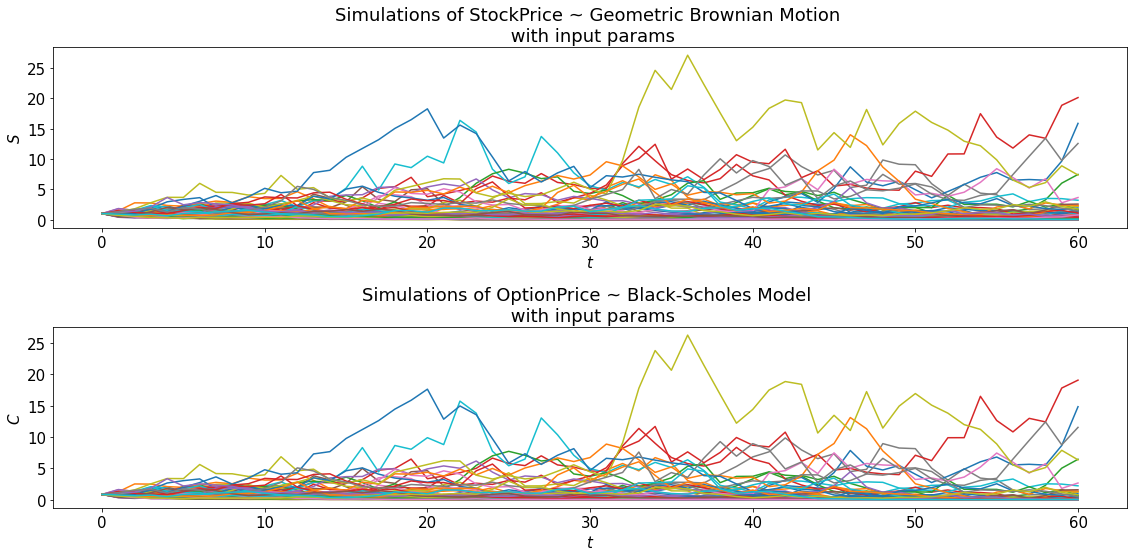

array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
       -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
       -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
        0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
        0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
        0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ])

In [583]:
## specify GLOBAL PARAMETERS for simulation and training
# BE CAREFUL WITH THESE GLOABAL PARAMETERS!!!
T = 60
num_episodes = 100

# generate data
S, C = dataGen(num_episodes)
assert S.shape == C.shape == (num_episodes, T+1)

# save simulation data
#np.save("dataGen_S.npy", S)
#np.save("dataGen_C.npy", C)

#S = np.load("dataGen_S.npy")
#C = np.load("dataGen_C.npy")

# viz simulated stock/option prices
plt.subplot(211)
plt.plot(S.T)
plt.xlabel("$t$")
plt.ylabel("$S$")
plt.title(
    f"Simulations of StockPrice ~ Geometric Brownian Motion \n with input params"
)

plt.subplot(212)
plt.plot(C.T)
plt.xlabel("$t$")
plt.ylabel("$C$")
plt.title(
    f"Simulations of OptionPrice ~ Black-Scholes Model \n with input params"
)

plt.tight_layout()
plt.show()

# define actions
#arms = np.arange(0, 1 + 0.04, 2 / 50)   # w.o. short-sale
arms = np.arange(-1, 1 + 0.04, 2 / 50)   # w. short-sale
arms[25] = 0
arms

### Common Training Func.

This trainer (objective function) may require substantial hyperparams tuning to converge; in such cases, users can refer to the Appendix for another version of adjusted trainer function to converge fast. 

In [579]:
## define common train func.
# given model variation, some args, e.g. the neural network, still need mannual config.
def trainBandit(model_cls, num_episodes, T, S, C, test_func, **kwargs):
    """Construct-trains a bandit with model-specific input arguments, and return training/test episodic cumulative rewards."""
    
    # construct model with specified args.
    model = model_cls(**kwargs)
    
    # create Oracle's action and reward buffers
    oracle_actions = []
    oracle_rewards = []
    
    # create episodic reward buffers
    train_episodic_cumRewards = np.empty(num_episodes)
    test_episodic_cumRewards = np.empty(num_episodes)
    
    # start training for each episode
    for episode, (stockPrice, optionPrice) in enumerate(zip(S,C)):

        # for each step
        for t in range(T):
            
            # let agent work
            context = (stockPrice[t], T-t)   # stockPrice_t, ttm (time to maturity)

            action = model.action(context)

            num_stocks = arms[action]
            reward = 0.01* (optionPrice[t] - optionPrice[t+1] + num_stocks * (stockPrice[t+1] - stockPrice[t])   # Delta wealth
                     - 0.1 * stockPrice[t] * np.abs(num_stocks if t == 0 else num_stocks - arms[model.data.actions[-1]])) \
                     - np.var([   # V approximation
                        optionPrice[i] - optionPrice[i+1] + num_stocks * (stockPrice[i+1] - stockPrice[i]) \
                        - 0.1 * stockPrice[i] * np.abs(num_stocks if i == 0 else num_stocks - arms[(model.data.actions + [action])[episode * T + i - 1]])       
                        for i in range(t+1) 
                            if (i == t) or ((action == model.data.actions[episode * T + i]) and all(np.array(context[:]) == model.data.contexts[episode * T + i]))
                        ])
            reward *= 100   # scalar gauging
            reward = np.min((reward, 2))   # reward cut-off

            model.update(context, action, reward)
            
            # compute Oracle's action and reward at each step
            true_actions_rewards = [
                np.min((100 * (0.01* (optionPrice[t] - optionPrice[t+1] + arms[action] * (stockPrice[t+1] - stockPrice[t])   # Delta wealth
                             - 0.1 * stockPrice[t] * np.abs(arms[action] if t == 0 else arms[action] - arms[oracle_actions[-1]])) \
                             - np.var([   # V approximation
                                optionPrice[i] - optionPrice[i+1] + arms[action] * (stockPrice[i+1] - stockPrice[i]) \
                                - 0.1 * stockPrice[i] * np.abs(arms[action] if i == 0 else arms[action] - arms[(oracle_actions + [action])[episode * T + i - 1]])       
                                for i in range(t+1) 
                                    if (i == t) or ((action == oracle_actions[episode * T + i]) and all(np.array(context[:]) == model.data.contexts[episode * T + i]))
                                ])), 2))
                for action in range(model.num_actions)
            ]
            oracle_actions.append(np.argmax(true_actions_rewards))
            oracle_rewards.append(np.max(true_actions_rewards))
        
        # compute episodic cumReward at the end of each training episode
        reward_train = np.sum(model.data.rewards[episode*60:])
        train_episodic_cumRewards[episode] = reward_train
        
        # test performance at the end of each episode
        reward_test = test_func(model)
        test_episodic_cumRewards[episode] = reward_test
        print(f"{model.__class__.__name__} | End of Episode: {episode}, Train Episodic cumReward: {reward_train}, Test Mean Episodic cumReward: {reward_test}")   
    
    # reduce Oracle's training performance statistics
    oracle_actions = np.array(oracle_actions).reshape(-1, T)
    oracle_rewards = np.array(oracle_rewards).reshape(-1, T)
    oracle_episodic_cumRewards = np.sum(oracle_rewards, axis=1)
    
    return model, train_episodic_cumRewards, test_episodic_cumRewards, oracle_episodic_cumRewards, oracle_actions

### Common Test Func.

In [580]:
# def performance-test func.
def testBandit(model, num_episodes=10, T=60):
    """Tests bandit performance, and returns mean episodic cumulative reward."""
    
    # generate test data, create context, action and reward buffer
    S, C = dataGen(num_episodes, T=T)
    contexts = [] 
    actions = []
    rewards = []
    
    # for each epsisode
    for episode in range(num_episodes):
        
        # get episodic test data
        stockPrice, optionPrice = S[episode], C[episode]
        
        # for each step
        for t in range(T):
            
            context = (stockPrice[t], T-t)   # stockPrice_t, ttm (time to maturity)
        
            action = model.predict(context)   # choose best action in prediction mode

            num_stocks = arms[action]
            reward = 0.01* (optionPrice[t] - optionPrice[t+1] + num_stocks * (stockPrice[t+1] - stockPrice[t])   # Delta wealth
                     - 0.1 * stockPrice[t] * np.abs(num_stocks if t == 0 else num_stocks - arms[actions[-1]])) \
                     - np.var([   # V approximation
                        optionPrice[i] - optionPrice[i+1] + num_stocks * (stockPrice[i+1] - stockPrice[i]) \
                        - 0.1 * stockPrice[i] * np.abs(num_stocks if i == 0 else num_stocks - arms[(actions + [action])[episode * T + i - 1]])       
                        for i in range(t+1) 
                            if (i == t) or ((action == actions[episode * T + i]) and (context == contexts[episode * T + i]))
                        ])
            reward *= 100   # scalar gauging factor
            reward = np.min((reward, 2))   # reward cut-off
            rewards.append(reward)
            
            # update buffers
            contexts.append(context)
            actions.append(action)
        
    return np.mean(rewards) * T

### BayesianNeuralBandit
-- R-CMAB Model

In [593]:
# define a neural network generator with specified architecture
def get_net(dim_context, num_actions):
    net = nn.Sequential(nn.Linear(dim_context,20), 
                        nn.ReLU(),
                        nn.Linear(20,20),
                        nn.ReLU(),
                        nn.Linear(20,20),
                        nn.ReLU(),
                        nn.Linear(20,num_actions))
    
    nn.init.uniform_(net[0].weight, a=-0.3, b=0.3)
    nn.init.uniform_(net[2].weight, a=-0.3, b=0.3)
    nn.init.uniform_(net[4].weight, a=-0.3, b=0.3)
    
    #def init_weights(m):
    #    if isinstance(m, nn.Linear):
    #        torch.nn.init.uniform_(m.weight, a=-0.3, b=0.3) 
    #net.apply(init_weights)
    return net

In [594]:
hedgeBandit_bayesianNeural, \
train_episodic_cumRewards_bayesianNeural, \
test_episodic_cumRewards_bayesianNeural, \
oracle_episodic_cumRewards_bayesianNeural, \
oracle_actions_bayesianNeural = trainBandit(
                            BayesianNeuralBandit,
                            num_episodes,
                            T=T,
                            S=S,
                            C=C,
                            test_func=testBandit,
                            num_actions=51,
                            context_dim=2,
                            latent_dim=20,
                            get_net=get_net,
                            learning_rate=0.1,
                            max_grad_norm=10.0,
                            lr_decay=1,
                            batch_size=512,
                            weight_decay=0,
                            show_training=False,
                            buffer_size=-1,
                            initial_pulls=10,
                            training_freq_baysian=1,
                            training_freq_network=50,
                            training_epochs=100,
                            do_scaling=False,
                            a0=6,
                            b0=6,
                            lambda_prior=0.25,
                            verbose=False,
                            summary_per_epoch=50)

BayesianNeuralBandit | End of Episode: 0, Train Episodic cumReward: -161.4817644280223, Test Mean Episodic cumReward: -200.9553302516023
BayesianNeuralBandit | End of Episode: 1, Train Episodic cumReward: -138.7799789268587, Test Mean Episodic cumReward: -214.56082200483888
BayesianNeuralBandit | End of Episode: 2, Train Episodic cumReward: -235.93530275607026, Test Mean Episodic cumReward: -129.90240382803276
BayesianNeuralBandit | End of Episode: 3, Train Episodic cumReward: -41.273515745144024, Test Mean Episodic cumReward: -237.72658904650774
BayesianNeuralBandit | End of Episode: 4, Train Episodic cumReward: -36.435986605813795, Test Mean Episodic cumReward: -131.0574090428707
BayesianNeuralBandit | End of Episode: 5, Train Episodic cumReward: -106.03944809955493, Test Mean Episodic cumReward: -11.222673146134753
BayesianNeuralBandit | End of Episode: 6, Train Episodic cumReward: -110.69979970746417, Test Mean Episodic cumReward: -142.35274011466072
BayesianNeuralBandit | End of E

BayesianNeuralBandit | End of Episode: 60, Train Episodic cumReward: -2.986383533551461, Test Mean Episodic cumReward: -5.281793400978439
BayesianNeuralBandit | End of Episode: 61, Train Episodic cumReward: -1.9409546336186358, Test Mean Episodic cumReward: -23.681096595218957
BayesianNeuralBandit | End of Episode: 62, Train Episodic cumReward: -0.14371083771798424, Test Mean Episodic cumReward: -3.2566285879834567
BayesianNeuralBandit | End of Episode: 63, Train Episodic cumReward: -13.285457686456855, Test Mean Episodic cumReward: -15.804585604334147
BayesianNeuralBandit | End of Episode: 64, Train Episodic cumReward: 0.008502159715812752, Test Mean Episodic cumReward: -2.293308253237213
BayesianNeuralBandit | End of Episode: 65, Train Episodic cumReward: 1.0569033230529354, Test Mean Episodic cumReward: -25.414771221054025
BayesianNeuralBandit | End of Episode: 66, Train Episodic cumReward: -31.05075672516876, Test Mean Episodic cumReward: -2.619430055372694
BayesianNeuralBandit | E

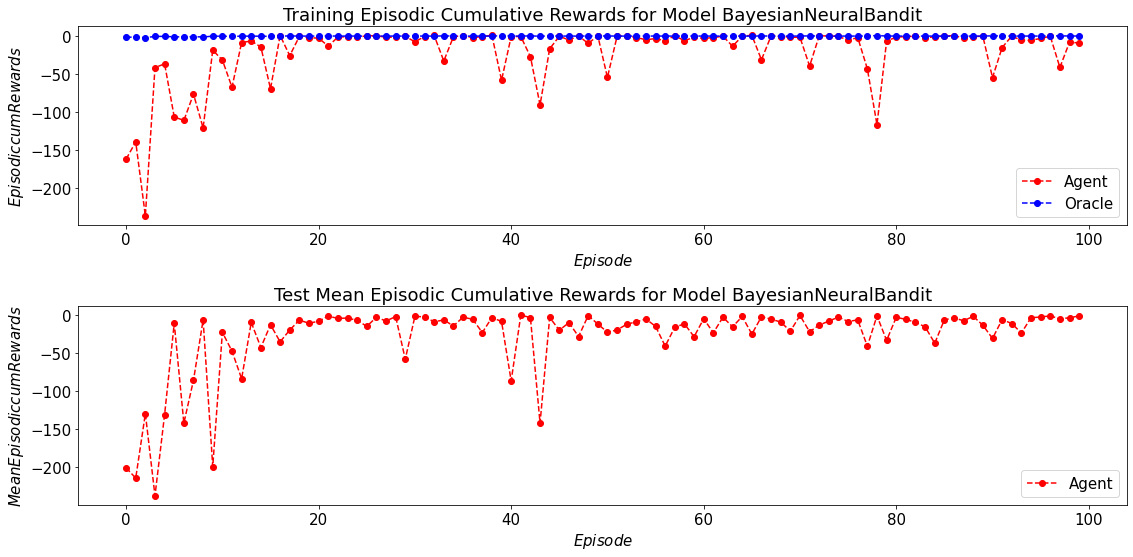

In [595]:
# viz training episodic cumulative rewards
plt.subplot(211)
plt.plot(range(num_episodes), 
         train_episodic_cumRewards_bayesianNeural, 
         linestyle='--', 
         marker='o', 
         color='r', 
         label='Agent')
plt.plot(range(num_episodes), 
         oracle_episodic_cumRewards_bayesianNeural, 
         linestyle='--', 
         marker='o', 
         color='b', 
         label='Oracle')

plt.legend()
plt.xlabel("$Episode$")
plt.ylabel("$Episodic cumRewards$")
plt.title(
    f"Training Episodic Cumulative Rewards for Model {hedgeBandit_bayesianNeural.__class__.__name__}"
)

# viz test episodic cumulative rewards
plt.subplot(212)
plt.plot(range(num_episodes), 
         test_episodic_cumRewards_bayesianNeural,
         linestyle='--', 
         marker='o', 
         color='r', 
         label='Agent')

plt.legend()
plt.xlabel("$Episode$")
plt.ylabel("$Mean Episodic cumRewards$")
plt.title(
    f"Test Mean Episodic Cumulative Rewards for Model {hedgeBandit_bayesianNeural.__class__.__name__}"
)


plt.tight_layout()
plt.show()

### NeuralGreedyBandit

In [304]:
# define a neural network generator with specified architecture
def get_net(dim_context, num_actions):
    net = nn.Sequential(nn.Linear(dim_context,20), 
                        nn.ReLU(),
                        nn.Linear(20,20),
                        nn.ReLU(),
                        nn.Linear(20,40),
                        nn.ReLU(),
                        nn.Linear(40,80),
                        nn.ReLU(),
                        nn.Linear(80,40),
                        nn.ReLU(),
                        nn.Linear(40,20),
                        nn.ReLU(),
                        nn.Linear(20,num_actions))
    
    nn.init.uniform_(net[0].weight, a=-0.3, b=0.3)
    nn.init.uniform_(net[2].weight, a=-0.3, b=0.3)
    nn.init.uniform_(net[4].weight, a=-0.3, b=0.3)
    nn.init.uniform_(net[6].weight, a=-0.3, b=0.3)
    nn.init.uniform_(net[8].weight, a=-0.3, b=0.3)
    nn.init.uniform_(net[10].weight, a=-0.3, b=0.3)
    #def init_weights(m):
    #    if isinstance(m, nn.Linear):
    #        torch.nn.init.uniform_(m.weight, a=-0.3, b=0.3) 
    #net.apply(init_weights)
    return net

In [305]:
hedgeBandit_neuralGreedy, \
train_episodic_cumRewards_neuralGreedy, \
test_episodic_cumRewards_neuralGreedy, \
oracle_episodic_cumRewards_neuralGreedy, \
oracle_actions_neuralGreedy = trainBandit(
                            NeuralGreedyBandit,
                            num_episodes,
                            T=T,
                            S=S,
                            C=C,
                            test_func=testBandit,
                            num_actions=51,
                            context_dim=2,
                            exploration_rate=0.1,
                            get_net=get_net,
                            learning_rate=0.001,
                            max_grad_norm=10.0,
                            lr_decay=1,
                            batch_size=512,
                            weight_decay=0,
                            show_training=False,
                            buffer_size=-1,
                            initial_pulls=5,
                            reset_lr=False,
                            training_freq_network=50,
                            training_epochs=100,
                            do_scaling=False,
                            verbose=False,
                            summary_per_epoch=50)

NeuralGreedyBandit | End of Episode: 0, Train Episodic cumReward: -1732.3142623904635, Test Mean Episodic cumReward: -27.999590838006043
NeuralGreedyBandit | End of Episode: 1, Train Episodic cumReward: -107.22784185650403, Test Mean Episodic cumReward: -82.62486918969792
NeuralGreedyBandit | End of Episode: 2, Train Episodic cumReward: -66.31424708666009, Test Mean Episodic cumReward: -228.30247633188827
NeuralGreedyBandit | End of Episode: 3, Train Episodic cumReward: -869.7284391177727, Test Mean Episodic cumReward: -282.19267675884566
NeuralGreedyBandit | End of Episode: 4, Train Episodic cumReward: -23.944747596303273, Test Mean Episodic cumReward: -363.7736595734694
NeuralGreedyBandit | End of Episode: 5, Train Episodic cumReward: -1949.39604885776, Test Mean Episodic cumReward: -4290.606622925278
NeuralGreedyBandit | End of Episode: 6, Train Episodic cumReward: -249.81652840206038, Test Mean Episodic cumReward: -404.0886097894214
NeuralGreedyBandit | End of Episode: 7, Train Epi

NeuralGreedyBandit | End of Episode: 60, Train Episodic cumReward: -13.05007542774863, Test Mean Episodic cumReward: -104.60061705245312
NeuralGreedyBandit | End of Episode: 61, Train Episodic cumReward: -23.248425615233813, Test Mean Episodic cumReward: -121.95727746364281
NeuralGreedyBandit | End of Episode: 62, Train Episodic cumReward: -10.02507651216277, Test Mean Episodic cumReward: -280.00655121082303
NeuralGreedyBandit | End of Episode: 63, Train Episodic cumReward: -12.580276601555473, Test Mean Episodic cumReward: -284.27536469186873
NeuralGreedyBandit | End of Episode: 64, Train Episodic cumReward: -57.81555283819276, Test Mean Episodic cumReward: -286.24970990804513
NeuralGreedyBandit | End of Episode: 65, Train Episodic cumReward: -18.347029332027848, Test Mean Episodic cumReward: -500.5176101805148
NeuralGreedyBandit | End of Episode: 66, Train Episodic cumReward: -29.788698696262628, Test Mean Episodic cumReward: -71.14818528954497
NeuralGreedyBandit | End of Episode: 67

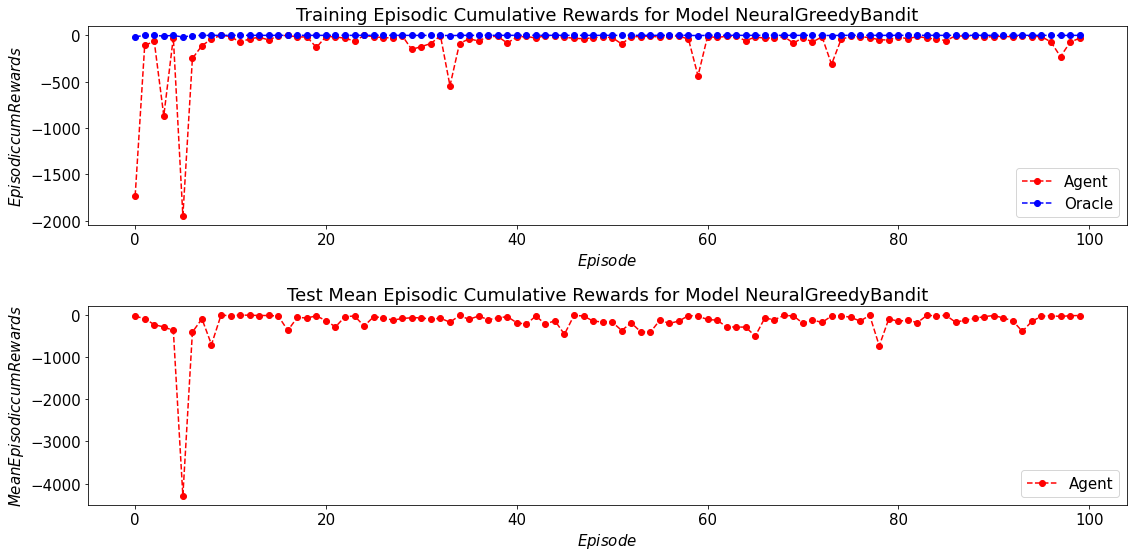

In [306]:
# viz training episodic cumulative rewards
plt.subplot(211)
plt.plot(range(num_episodes), 
         train_episodic_cumRewards_neuralGreedy, 
         linestyle='--', 
         marker='o', 
         color='r', 
         label='Agent')
plt.plot(range(num_episodes), 
         oracle_episodic_cumRewards_neuralGreedy, 
         linestyle='--', 
         marker='o', 
         color='b', 
         label='Oracle')

plt.legend()
plt.xlabel("$Episode$")
plt.ylabel("$Episodic cumRewards$")
plt.title(
    f"Training Episodic Cumulative Rewards for Model {hedgeBandit_neuralGreedy.__class__.__name__}"
)

# viz test episodic cumulative rewards
plt.subplot(212)
plt.plot(range(num_episodes), 
         test_episodic_cumRewards_neuralGreedy,
         linestyle='--', 
         marker='o', 
         color='r', 
         label='Agent')

plt.legend()
plt.xlabel("$Episode$")
plt.ylabel("$Mean Episodic cumRewards$")
plt.title(
    f"Test Mean Episodic Cumulative Rewards for Model {hedgeBandit_neuralGreedy.__class__.__name__}"
)


plt.tight_layout()
plt.show()

### NaiveBandit

In [307]:
hedgeBandit_naiveBandit, \
train_episodic_cumRewards_naiveBandit, \
test_episodic_cumRewards_naiveBandit, \
oracle_episodic_cumRewards_naiveBandit, \
oracle_actions_naiveBandit = trainBandit(
                            NaiveBandit,
                            num_episodes,
                            T=T,
                            S=S,
                            C=C,
                            test_func=testBandit,
                            num_actions=51,
                            context_dim=2,
                            exploration_rate=0.3,
                            initial_pulls=5,
                            buffer_size=-1)

NaiveBandit | End of Episode: 0, Train Episodic cumReward: -1732.3142623904635, Test Mean Episodic cumReward: -36.92699155432648
NaiveBandit | End of Episode: 1, Train Episodic cumReward: -107.22784185650403, Test Mean Episodic cumReward: -103.61127477967784
NaiveBandit | End of Episode: 2, Train Episodic cumReward: -66.31424708666009, Test Mean Episodic cumReward: -206.40947419949416
NaiveBandit | End of Episode: 3, Train Episodic cumReward: -869.7284391177727, Test Mean Episodic cumReward: -376.45036590168206
NaiveBandit | End of Episode: 4, Train Episodic cumReward: -21.568786196172077, Test Mean Episodic cumReward: -37.85655416238504
NaiveBandit | End of Episode: 5, Train Episodic cumReward: -625.6381618281687, Test Mean Episodic cumReward: -87.45891828074734
NaiveBandit | End of Episode: 6, Train Episodic cumReward: -89.54422095117584, Test Mean Episodic cumReward: -87.03992988372673
NaiveBandit | End of Episode: 7, Train Episodic cumReward: -48.34246478185875, Test Mean Episodic 

NaiveBandit | End of Episode: 64, Train Episodic cumReward: -91.77277772809938, Test Mean Episodic cumReward: -228.46559325918562
NaiveBandit | End of Episode: 65, Train Episodic cumReward: -32.855564688315816, Test Mean Episodic cumReward: -232.54626802839206
NaiveBandit | End of Episode: 66, Train Episodic cumReward: -64.43065277479079, Test Mean Episodic cumReward: -47.06670112933064
NaiveBandit | End of Episode: 67, Train Episodic cumReward: -46.707915479913424, Test Mean Episodic cumReward: -231.98941740326725
NaiveBandit | End of Episode: 68, Train Episodic cumReward: -36.771768894694986, Test Mean Episodic cumReward: -30.97519140344273
NaiveBandit | End of Episode: 69, Train Episodic cumReward: -166.23644918917512, Test Mean Episodic cumReward: -51.304773192612046
NaiveBandit | End of Episode: 70, Train Episodic cumReward: -22.306203965869624, Test Mean Episodic cumReward: -35.08309000434124
NaiveBandit | End of Episode: 71, Train Episodic cumReward: -206.17762158519648, Test Me

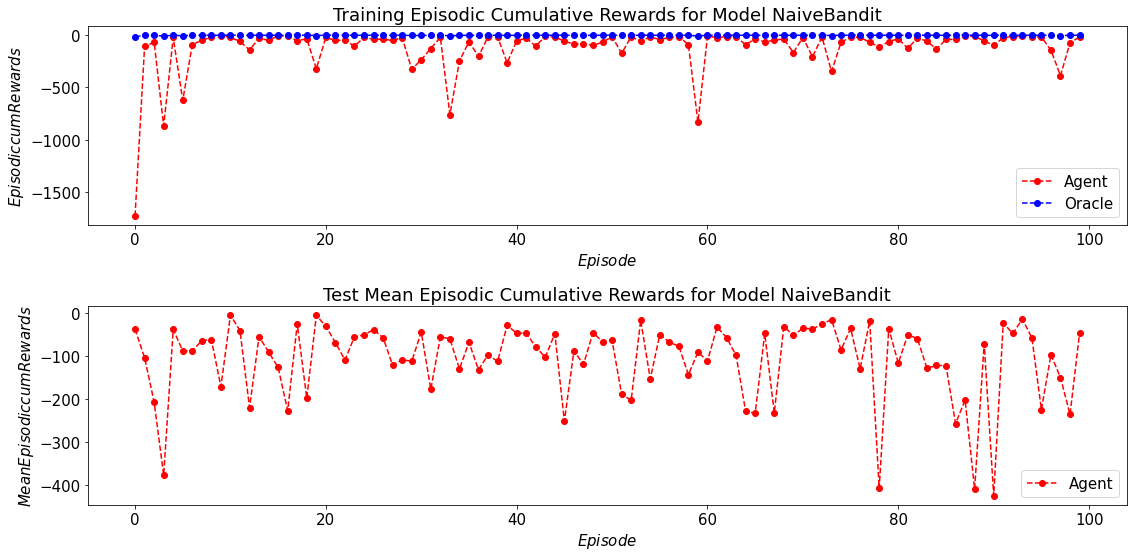

In [308]:
# viz training episodic cumulative rewards
plt.subplot(211)
plt.plot(range(num_episodes), 
         train_episodic_cumRewards_naiveBandit, 
         linestyle='--', 
         marker='o', 
         color='r', 
         label='Agent')
plt.plot(range(num_episodes), 
         oracle_episodic_cumRewards_naiveBandit, 
         linestyle='--', 
         marker='o', 
         color='b', 
         label='Oracle')

plt.legend()
plt.xlabel("$Episode$")
plt.ylabel("$Episodic cumRewards$")
plt.title(
    f"Training Episodic Cumulative Rewards for Model {hedgeBandit_naiveBandit.__class__.__name__}"
)

# viz test episodic cumulative rewards
plt.subplot(212)
plt.plot(range(num_episodes), 
         test_episodic_cumRewards_naiveBandit,
         linestyle='--', 
         marker='o', 
         color='r', 
         label='Agent')

plt.legend()
plt.xlabel("$Episode$")
plt.ylabel("$Mean Episodic cumRewards$")
plt.title(
    f"Test Mean Episodic Cumulative Rewards for Model {hedgeBandit_naiveBandit.__class__.__name__}"
)


plt.tight_layout()
plt.show()

### RandomBandit

In [592]:
## random pull, baseline
hedgeBandit_randomBandit, \
train_episodic_cumRewards_randomBandit, \
test_episodic_cumRewards_randomBandit, \
oracle_episodic_cumRewards_randomBandit, \
oracle_actions_randomBandit = trainBandit(
                            RandomBandit,
                            num_episodes,
                            T=T,
                            S=S,
                            C=C,
                            test_func=testBandit,
                            num_actions=51,
                            context_dim=2)

RandomBandit | End of Episode: 0, Train Episodic cumReward: -150.4915954265212, Test Mean Episodic cumReward: -246.12595150254808
RandomBandit | End of Episode: 1, Train Episodic cumReward: -160.589263700496, Test Mean Episodic cumReward: -7.323599414056071
RandomBandit | End of Episode: 2, Train Episodic cumReward: -308.9017888046904, Test Mean Episodic cumReward: -110.01749046392604
RandomBandit | End of Episode: 3, Train Episodic cumReward: -29.398995483044835, Test Mean Episodic cumReward: -285.7917793872991
RandomBandit | End of Episode: 4, Train Episodic cumReward: -29.893064585148487, Test Mean Episodic cumReward: -239.62698224332172
RandomBandit | End of Episode: 5, Train Episodic cumReward: -128.5602063356249, Test Mean Episodic cumReward: -112.89049018257568
RandomBandit | End of Episode: 6, Train Episodic cumReward: -113.46672422030254, Test Mean Episodic cumReward: -175.39147606427696
RandomBandit | End of Episode: 7, Train Episodic cumReward: -60.63226584002811, Test Mean 

RandomBandit | End of Episode: 63, Train Episodic cumReward: -271.1053132401293, Test Mean Episodic cumReward: -77.1031592369459
RandomBandit | End of Episode: 64, Train Episodic cumReward: -42.957343316118155, Test Mean Episodic cumReward: -1.584564604946584
RandomBandit | End of Episode: 65, Train Episodic cumReward: -19.292172557575558, Test Mean Episodic cumReward: -238.51983707751313
RandomBandit | End of Episode: 66, Train Episodic cumReward: -381.111170267582, Test Mean Episodic cumReward: -253.90710363522612
RandomBandit | End of Episode: 67, Train Episodic cumReward: -31.68971982240585, Test Mean Episodic cumReward: -38.59540000734886
RandomBandit | End of Episode: 68, Train Episodic cumReward: -59.20820139945304, Test Mean Episodic cumReward: -388.5196721899752
RandomBandit | End of Episode: 69, Train Episodic cumReward: -82.4408637924164, Test Mean Episodic cumReward: -173.74141627243569
RandomBandit | End of Episode: 70, Train Episodic cumReward: -77.0307117617584, Test Mea

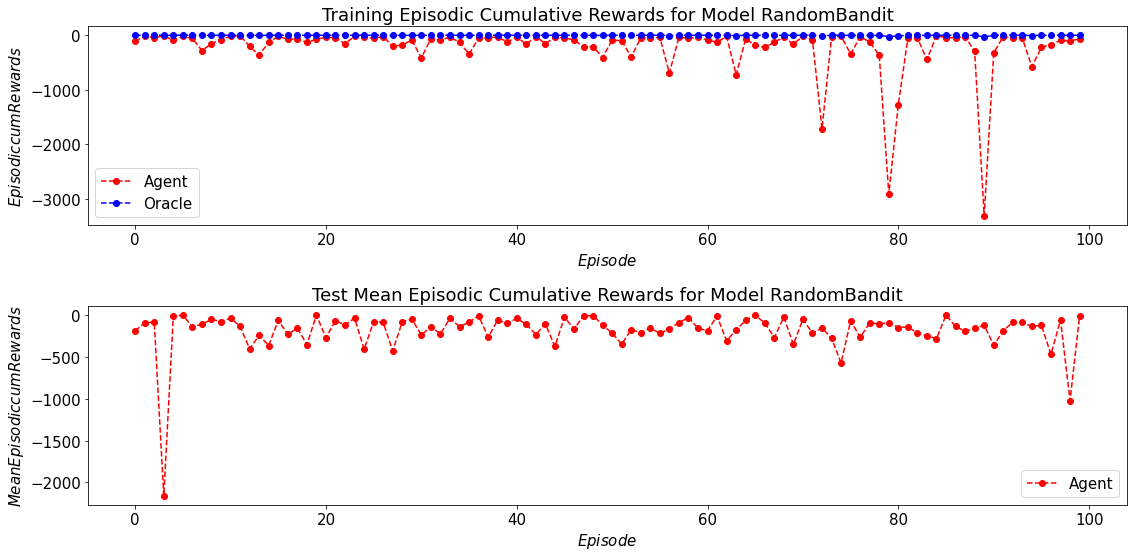

In [539]:
# viz training episodic cumulative rewards
plt.subplot(211)
plt.plot(range(num_episodes), 
         train_episodic_cumRewards_randomBandit, 
         linestyle='--', 
         marker='o', 
         color='r', 
         label='Agent')
plt.plot(range(num_episodes), 
         oracle_episodic_cumRewards_randomBandit, 
         linestyle='--', 
         marker='o', 
         color='b', 
         label='Oracle')

plt.legend()
plt.xlabel("$Episode$")
plt.ylabel("$Episodic cumRewards$")
plt.title(
    f"Training Episodic Cumulative Rewards for Model {hedgeBandit_randomBandit.__class__.__name__}"
)

# viz test episodic cumulative rewards
plt.subplot(212)
plt.plot(range(num_episodes), 
         test_episodic_cumRewards_randomBandit,
         linestyle='--', 
         marker='o', 
         color='r', 
         label='Agent')

plt.legend()
plt.xlabel("$Episode$")
plt.ylabel("$Mean Episodic cumRewards$")
plt.title(
    f"Test Mean Episodic Cumulative Rewards for Model {hedgeBandit_randomBandit.__class__.__name__}"
)


plt.tight_layout()
plt.show()

### BayesianNeuralBandit Hyper-Parameter Tuning via Bayesian Optimization

In [258]:
# define hyperparams bounds
bds = [
    {'name': 'learning_rate', 'type': 'discrete', 'domain': (0.00001, 0.001, 0.1, 10.0)},
    {'name': 'max_grad_norm', 'type': 'discrete', 'domain': (5.0, 10.0, 50.0)},
    {'name': 'lr_decay', 'type': 'discrete', 'domain': (1, 5)},
    {'name': 'batch_size', 'type': 'discrete', 'domain': (128, 512, 1024)},
    {'name': 'initial_pulls', 'type': 'discrete', 'domain': (5, 20)},
    {'name': 'training_freq_network', 'type': 'discrete', 'domain': (50, 100, 150)},
    {'name': 'training_epochs', 'type': 'discrete', 'domain': (50, 100)},
    {'name': 'do_scaling', 'type': 'discrete', 'domain': (True, False)}
]


# define objective function to optimize using Bayesian
def obj_func(params):
    params = params[0]
    
    # declare local variables as experiment settings
    T = 60
    num_episodes = 100

    # generate data
    S, C = dataGen(num_episodes)
    assert S.shape == C.shape == (num_episodes, T+1)

    # define actions
    #arms = np.arange(0, 1 + 0.04, 2 / 50)   # w.o. short-sale
    arms = np.arange(-1, 1 + 0.04, 2 / 50)   # w. short-sale
    arms[25] = 0
    #arms
    
    # define a neural network generator with specified architecture
    def get_net(dim_context, num_actions):
        net = nn.Sequential(nn.Linear(dim_context,20), 
                            nn.ReLU(),
                            nn.Linear(20,20),
                            nn.ReLU(),
                            nn.Linear(20,20),
                            nn.ReLU(),
                            nn.Linear(20,num_actions))

        nn.init.uniform_(net[0].weight, a=-0.3, b=0.3)
        nn.init.uniform_(net[2].weight, a=-0.3, b=0.3)
        nn.init.uniform_(net[4].weight, a=-0.3, b=0.3)

        #def init_weights(m):
        #    if isinstance(m, nn.Linear):params     #        torch.nn.init.uniform_(m.weight, a=-0.3, b=0.3) 
        #net.apply(init_weights)
        return net

    _, \
    train_episodic_cumRewards_bayesianNeural_, \
    _, \
    _, \
    _ = trainBandit(
            BayesianNeuralBandit,
            num_episodes,
            T=T,
            S=S,
            C=C,
            test_func=testBandit,
            num_actions=51,
            context_dim=2,
            latent_dim=20,
            get_net=get_net,
            learning_rate=params[0],
            max_grad_norm=params[1],
            lr_decay=params[2],
            batch_size=int(params[3]),
            weight_decay=0,
            show_training=False,
            buffer_size=-1,
            initial_pulls=int(params[4]),
            training_freq_baysian=1,
            training_freq_network=int(params[5]),
            training_epochs=int(params[6]),
            do_scaling=params[7],
            a0=6,
            b0=6,
            lambda_prior=0.25,
            verbose=False,
            summary_per_epoch=50)
        
    print(f'BO Run ended for params {params}')
    return np.mean(train_episodic_cumRewards_bayesianNeural_)

In [259]:
# instantiate optimizer
optimizer_hedgeBandit_bayesianNeural = BayesianOptimization(
                                    f = obj_func, 
                                    domain = bds,
                                    model_type = 'GP',
                                    initial_design_numdata = 5,
                                    acquisition_type = 'EI',
                                    acquisition_jitter = 0.05,
                                    exact_feval = True, 
                                    maximize = True)

# optimize up to 10 runs after initialization
optimizer_hedgeBandit_bayesianNeural.run_optimization(max_iter = 50)

BayesianNeuralBandit | End of Episode: 0, Train Episodic cumReward: -21.034489821264067, Test Mean Episodic cumReward: -54.221224744715485
BayesianNeuralBandit | End of Episode: 1, Train Episodic cumReward: -35.46651474254362, Test Mean Episodic cumReward: -170.63709118280298
BayesianNeuralBandit | End of Episode: 2, Train Episodic cumReward: -77.33832411779272, Test Mean Episodic cumReward: -210.26624053288552
BayesianNeuralBandit | End of Episode: 3, Train Episodic cumReward: -31.732075893171952, Test Mean Episodic cumReward: -223.72339704688832
BayesianNeuralBandit | End of Episode: 4, Train Episodic cumReward: -52.7024787607519, Test Mean Episodic cumReward: -22.13639795404532
BayesianNeuralBandit | End of Episode: 5, Train Episodic cumReward: -16.467162983544714, Test Mean Episodic cumReward: -188.62667071696774
BayesianNeuralBandit | End of Episode: 6, Train Episodic cumReward: -403.863184905301, Test Mean Episodic cumReward: -233.9262274001387
BayesianNeuralBandit | End of Episo

BayesianNeuralBandit | End of Episode: 60, Train Episodic cumReward: -35.81275958486262, Test Mean Episodic cumReward: -402.1690701843756
BayesianNeuralBandit | End of Episode: 61, Train Episodic cumReward: -693.2142983591339, Test Mean Episodic cumReward: -65.39661637059147
BayesianNeuralBandit | End of Episode: 62, Train Episodic cumReward: -44.91863986724169, Test Mean Episodic cumReward: -133.09149431224046
BayesianNeuralBandit | End of Episode: 63, Train Episodic cumReward: -354.65641188834627, Test Mean Episodic cumReward: -100.70044303574502
BayesianNeuralBandit | End of Episode: 64, Train Episodic cumReward: -1631.479488995893, Test Mean Episodic cumReward: -110.57777523708145
BayesianNeuralBandit | End of Episode: 65, Train Episodic cumReward: -74.89628968904323, Test Mean Episodic cumReward: -6.385372774191708
BayesianNeuralBandit | End of Episode: 66, Train Episodic cumReward: -59.673104983038485, Test Mean Episodic cumReward: -135.96230887341787
BayesianNeuralBandit | End o

BayesianNeuralBandit | End of Episode: 19, Train Episodic cumReward: -28.27747461411159, Test Mean Episodic cumReward: -136.79638283948188
BayesianNeuralBandit | End of Episode: 20, Train Episodic cumReward: -5.551151456442368, Test Mean Episodic cumReward: -100.45407817218724
BayesianNeuralBandit | End of Episode: 21, Train Episodic cumReward: -26.079840414684487, Test Mean Episodic cumReward: -15.159084513612397
BayesianNeuralBandit | End of Episode: 22, Train Episodic cumReward: -74.38686626230775, Test Mean Episodic cumReward: -115.92255479020878
BayesianNeuralBandit | End of Episode: 23, Train Episodic cumReward: -22.436373863251017, Test Mean Episodic cumReward: -13.584988415729406
BayesianNeuralBandit | End of Episode: 24, Train Episodic cumReward: -2.8326757466737975, Test Mean Episodic cumReward: -7.05003317680691
BayesianNeuralBandit | End of Episode: 25, Train Episodic cumReward: -28.243023211413664, Test Mean Episodic cumReward: -24.028879434296062
BayesianNeuralBandit | En

BayesianNeuralBandit | End of Episode: 78, Train Episodic cumReward: -73.69584412213872, Test Mean Episodic cumReward: -83.7578457317432
BayesianNeuralBandit | End of Episode: 79, Train Episodic cumReward: -156.09851973293382, Test Mean Episodic cumReward: -191.86770010076603
BayesianNeuralBandit | End of Episode: 80, Train Episodic cumReward: -91.07159183945586, Test Mean Episodic cumReward: -182.70699732508697
BayesianNeuralBandit | End of Episode: 81, Train Episodic cumReward: -39.10344690491806, Test Mean Episodic cumReward: -282.6063861133275
BayesianNeuralBandit | End of Episode: 82, Train Episodic cumReward: -78.21217990945419, Test Mean Episodic cumReward: -25.285018032557335
BayesianNeuralBandit | End of Episode: 83, Train Episodic cumReward: -300.42700651546744, Test Mean Episodic cumReward: -1.809400635220431
BayesianNeuralBandit | End of Episode: 84, Train Episodic cumReward: -42.505290421422224, Test Mean Episodic cumReward: -4.411823971326148
BayesianNeuralBandit | End of

BayesianNeuralBandit | End of Episode: 37, Train Episodic cumReward: 0.654090177072803, Test Mean Episodic cumReward: -2.0479607761081944
BayesianNeuralBandit | End of Episode: 38, Train Episodic cumReward: -5.410806014069463, Test Mean Episodic cumReward: -21.079185275299647
BayesianNeuralBandit | End of Episode: 39, Train Episodic cumReward: -2.1667920883255767, Test Mean Episodic cumReward: -20.273317466188754
BayesianNeuralBandit | End of Episode: 40, Train Episodic cumReward: -11.274522324553573, Test Mean Episodic cumReward: -3.59686089860665
BayesianNeuralBandit | End of Episode: 41, Train Episodic cumReward: 1.0841841133553112, Test Mean Episodic cumReward: -4.252734922124079
BayesianNeuralBandit | End of Episode: 42, Train Episodic cumReward: 0.9215057752449066, Test Mean Episodic cumReward: -11.73606422065928
BayesianNeuralBandit | End of Episode: 43, Train Episodic cumReward: -28.21868014505549, Test Mean Episodic cumReward: -12.616099627397828
BayesianNeuralBandit | End of 

BayesianNeuralBandit | End of Episode: 96, Train Episodic cumReward: -0.6350652569951512, Test Mean Episodic cumReward: -24.060584968997386
BayesianNeuralBandit | End of Episode: 97, Train Episodic cumReward: 1.0764399737926134, Test Mean Episodic cumReward: -103.79501815360057
BayesianNeuralBandit | End of Episode: 98, Train Episodic cumReward: -0.5103182978165864, Test Mean Episodic cumReward: -4.836132339197421
BayesianNeuralBandit | End of Episode: 99, Train Episodic cumReward: -1.0178530650692195, Test Mean Episodic cumReward: -13.323491992746323
BO Run ended for params [ 10.  50.   1. 128.   5. 150.  50.   1.]
BayesianNeuralBandit | End of Episode: 0, Train Episodic cumReward: -372.3898948336927, Test Mean Episodic cumReward: -57.39343053565282
BayesianNeuralBandit | End of Episode: 1, Train Episodic cumReward: -908.5584328502596, Test Mean Episodic cumReward: -110.4336879087416
BayesianNeuralBandit | End of Episode: 2, Train Episodic cumReward: -39.3547890956811, Test Mean Episo

BayesianNeuralBandit | End of Episode: 55, Train Episodic cumReward: -3.871090491443878, Test Mean Episodic cumReward: -1.6340179142747753
BayesianNeuralBandit | End of Episode: 56, Train Episodic cumReward: -2.8468216510567483, Test Mean Episodic cumReward: -13.236110137531185
BayesianNeuralBandit | End of Episode: 57, Train Episodic cumReward: 0.083738815971095, Test Mean Episodic cumReward: -7.911127163485876
BayesianNeuralBandit | End of Episode: 58, Train Episodic cumReward: -29.83064951070834, Test Mean Episodic cumReward: -8.141751954516415
BayesianNeuralBandit | End of Episode: 59, Train Episodic cumReward: -1.8976564808494172, Test Mean Episodic cumReward: -10.141421889382514
BayesianNeuralBandit | End of Episode: 60, Train Episodic cumReward: -1.1810984887528648, Test Mean Episodic cumReward: -8.49956931561308
BayesianNeuralBandit | End of Episode: 61, Train Episodic cumReward: -0.6566956537925407, Test Mean Episodic cumReward: -1.602224204903991
BayesianNeuralBandit | End of

BayesianNeuralBandit | End of Episode: 14, Train Episodic cumReward: -37.95553770678706, Test Mean Episodic cumReward: -178.09395162553477
BayesianNeuralBandit | End of Episode: 15, Train Episodic cumReward: -126.30836121778788, Test Mean Episodic cumReward: -320.69752763034614
BayesianNeuralBandit | End of Episode: 16, Train Episodic cumReward: -27.56503599982451, Test Mean Episodic cumReward: -197.8517728041862
BayesianNeuralBandit | End of Episode: 17, Train Episodic cumReward: -31.619797280951246, Test Mean Episodic cumReward: -35.991486515001114
BayesianNeuralBandit | End of Episode: 18, Train Episodic cumReward: -45.71142374022054, Test Mean Episodic cumReward: -176.44228943383385
BayesianNeuralBandit | End of Episode: 19, Train Episodic cumReward: -360.34454984660397, Test Mean Episodic cumReward: -6.714855081018186
BayesianNeuralBandit | End of Episode: 20, Train Episodic cumReward: -30.912896291293315, Test Mean Episodic cumReward: -113.69966831677634
BayesianNeuralBandit | En

BayesianNeuralBandit | End of Episode: 74, Train Episodic cumReward: -104.87939129829431, Test Mean Episodic cumReward: -80.21625172179704
BayesianNeuralBandit | End of Episode: 75, Train Episodic cumReward: -137.72475859442977, Test Mean Episodic cumReward: -254.06372126668074
BayesianNeuralBandit | End of Episode: 76, Train Episodic cumReward: -121.93157706835014, Test Mean Episodic cumReward: -121.82651002627433
BayesianNeuralBandit | End of Episode: 77, Train Episodic cumReward: -18.262308489506538, Test Mean Episodic cumReward: -76.91315965006459
BayesianNeuralBandit | End of Episode: 78, Train Episodic cumReward: -114.57886066420436, Test Mean Episodic cumReward: -27.382056242553862
BayesianNeuralBandit | End of Episode: 79, Train Episodic cumReward: -24.850168512466254, Test Mean Episodic cumReward: -105.79744538982968
BayesianNeuralBandit | End of Episode: 80, Train Episodic cumReward: -29.016735458929574, Test Mean Episodic cumReward: -7.015732713528868
BayesianNeuralBandit | 

BayesianNeuralBandit | End of Episode: 33, Train Episodic cumReward: -18.54067523315991, Test Mean Episodic cumReward: -266.0123888678409
BayesianNeuralBandit | End of Episode: 34, Train Episodic cumReward: -3.8892428271039603, Test Mean Episodic cumReward: -496.20905232999905
BayesianNeuralBandit | End of Episode: 35, Train Episodic cumReward: -59.13928430419425, Test Mean Episodic cumReward: -105.48127302839335
BayesianNeuralBandit | End of Episode: 36, Train Episodic cumReward: -96.41627448340876, Test Mean Episodic cumReward: -160.15925649779038
BayesianNeuralBandit | End of Episode: 37, Train Episodic cumReward: -31.191949189798834, Test Mean Episodic cumReward: -122.50846794164963
BayesianNeuralBandit | End of Episode: 38, Train Episodic cumReward: -32.70116112002184, Test Mean Episodic cumReward: -113.25824806476896
BayesianNeuralBandit | End of Episode: 39, Train Episodic cumReward: -26.55017060586917, Test Mean Episodic cumReward: -153.88368773892992
BayesianNeuralBandit | End

BayesianNeuralBandit | End of Episode: 92, Train Episodic cumReward: -58.1228286768754, Test Mean Episodic cumReward: -228.7975776132027
BayesianNeuralBandit | End of Episode: 93, Train Episodic cumReward: -128.9536967441588, Test Mean Episodic cumReward: -619.0924188456489
BayesianNeuralBandit | End of Episode: 94, Train Episodic cumReward: -144.72147408833047, Test Mean Episodic cumReward: -216.79953613546155
BayesianNeuralBandit | End of Episode: 95, Train Episodic cumReward: -118.96977773348276, Test Mean Episodic cumReward: -475.71805897622966
BayesianNeuralBandit | End of Episode: 96, Train Episodic cumReward: -61.520882149349745, Test Mean Episodic cumReward: -175.88192314753005
BayesianNeuralBandit | End of Episode: 97, Train Episodic cumReward: -391.9714284896168, Test Mean Episodic cumReward: -86.58161966435097
BayesianNeuralBandit | End of Episode: 98, Train Episodic cumReward: -48.271403343030904, Test Mean Episodic cumReward: -723.149502022798
BayesianNeuralBandit | End of

BayesianNeuralBandit | End of Episode: 51, Train Episodic cumReward: -13.259338985239015, Test Mean Episodic cumReward: -32.088212044182576
BayesianNeuralBandit | End of Episode: 52, Train Episodic cumReward: -17.864601907008616, Test Mean Episodic cumReward: -44.14806890144513
BayesianNeuralBandit | End of Episode: 53, Train Episodic cumReward: -14.951243693146084, Test Mean Episodic cumReward: -65.09822032586804
BayesianNeuralBandit | End of Episode: 54, Train Episodic cumReward: -49.149571185834944, Test Mean Episodic cumReward: -163.6501531822063
BayesianNeuralBandit | End of Episode: 55, Train Episodic cumReward: -8.077734303496644, Test Mean Episodic cumReward: -112.2478058713024
BayesianNeuralBandit | End of Episode: 56, Train Episodic cumReward: -36.04487755526788, Test Mean Episodic cumReward: -119.04918575478389
BayesianNeuralBandit | End of Episode: 57, Train Episodic cumReward: -80.21524695816738, Test Mean Episodic cumReward: -50.5969558636667
BayesianNeuralBandit | End of

BayesianNeuralBandit | End of Episode: 10, Train Episodic cumReward: -16.22307062030069, Test Mean Episodic cumReward: -313.96667082121587
BayesianNeuralBandit | End of Episode: 11, Train Episodic cumReward: -77.01989181772336, Test Mean Episodic cumReward: -73.04089498109144
BayesianNeuralBandit | End of Episode: 12, Train Episodic cumReward: -165.0393230946097, Test Mean Episodic cumReward: -88.92811589593487
BayesianNeuralBandit | End of Episode: 13, Train Episodic cumReward: -121.32518947819213, Test Mean Episodic cumReward: -205.65049971496123
BayesianNeuralBandit | End of Episode: 14, Train Episodic cumReward: -97.48242738512452, Test Mean Episodic cumReward: -80.47272963067388
BayesianNeuralBandit | End of Episode: 15, Train Episodic cumReward: -97.53670161218778, Test Mean Episodic cumReward: -223.58927000276734
BayesianNeuralBandit | End of Episode: 16, Train Episodic cumReward: -316.38458911837535, Test Mean Episodic cumReward: -175.55026814000914
BayesianNeuralBandit | End o

BayesianNeuralBandit | End of Episode: 69, Train Episodic cumReward: 1.0158496618018085, Test Mean Episodic cumReward: -5.463007260726868
BayesianNeuralBandit | End of Episode: 70, Train Episodic cumReward: 0.2219565552726479, Test Mean Episodic cumReward: -2.71519442124791
BayesianNeuralBandit | End of Episode: 71, Train Episodic cumReward: -2.742681790434109, Test Mean Episodic cumReward: -13.653035648958149
BayesianNeuralBandit | End of Episode: 72, Train Episodic cumReward: -4.60124744480696, Test Mean Episodic cumReward: -6.791178890656465
BayesianNeuralBandit | End of Episode: 73, Train Episodic cumReward: -6.217344850966627, Test Mean Episodic cumReward: -4.455493056490856
BayesianNeuralBandit | End of Episode: 74, Train Episodic cumReward: -1.2874192860983011, Test Mean Episodic cumReward: -3.6493077831038816
BayesianNeuralBandit | End of Episode: 75, Train Episodic cumReward: -1.1550062101559635, Test Mean Episodic cumReward: -8.69891064456167
BayesianNeuralBandit | End of Epi

BayesianNeuralBandit | End of Episode: 28, Train Episodic cumReward: -2.7434284450692776, Test Mean Episodic cumReward: -10.036865280832664
BayesianNeuralBandit | End of Episode: 29, Train Episodic cumReward: 0.5886586301810208, Test Mean Episodic cumReward: -16.12711262329724
BayesianNeuralBandit | End of Episode: 30, Train Episodic cumReward: -2.3467545074676996, Test Mean Episodic cumReward: -5.985745272413473
BayesianNeuralBandit | End of Episode: 31, Train Episodic cumReward: -5.415493119598729, Test Mean Episodic cumReward: -26.28901582153992
BayesianNeuralBandit | End of Episode: 32, Train Episodic cumReward: -5.689416354932681, Test Mean Episodic cumReward: -4.668539479029152
BayesianNeuralBandit | End of Episode: 33, Train Episodic cumReward: -0.4984502801276675, Test Mean Episodic cumReward: -31.876013818510238
BayesianNeuralBandit | End of Episode: 34, Train Episodic cumReward: -358.55546669288333, Test Mean Episodic cumReward: -32.438107166464434
BayesianNeuralBandit | End 

BayesianNeuralBandit | End of Episode: 87, Train Episodic cumReward: -3.009616330983394, Test Mean Episodic cumReward: -17.168551488818004
BayesianNeuralBandit | End of Episode: 88, Train Episodic cumReward: -7.6674343721572935, Test Mean Episodic cumReward: -10.02804102460471
BayesianNeuralBandit | End of Episode: 89, Train Episodic cumReward: 1.0204532704958387, Test Mean Episodic cumReward: -1.0437325659478098
BayesianNeuralBandit | End of Episode: 90, Train Episodic cumReward: -2.8870972207438617, Test Mean Episodic cumReward: -9.113002530299305
BayesianNeuralBandit | End of Episode: 91, Train Episodic cumReward: -1.1869741660420732, Test Mean Episodic cumReward: -5.7024701690942665
BayesianNeuralBandit | End of Episode: 92, Train Episodic cumReward: -7.722355652164627, Test Mean Episodic cumReward: -4.872391121246335
BayesianNeuralBandit | End of Episode: 93, Train Episodic cumReward: -4.759825571979887, Test Mean Episodic cumReward: -2.2920605640624285
BayesianNeuralBandit | End 

In [260]:
# save tuning results
optimizer_hedgeBandit_bayesianNeural.save_evaluations("optimizer_hedgeBandit_bayesianNeural_BO_evals")

Re-fit a BayesianNeuralBandit with best hyperparameters from BO

In [311]:
# define a neural network generator with specified architecture
def get_net(dim_context, num_actions):
    net = nn.Sequential(nn.Linear(dim_context,20), 
                        nn.ReLU(),
                        nn.Linear(20,20),
                        nn.ReLU(),
                        nn.Linear(20,20),
                        nn.ReLU(),
                        nn.Linear(20,num_actions))
    
    nn.init.uniform_(net[0].weight, a=-0.3, b=0.3)
    nn.init.uniform_(net[2].weight, a=-0.3, b=0.3)
    nn.init.uniform_(net[4].weight, a=-0.3, b=0.3)
    
    #def init_weights(m):
    #    if isinstance(m, nn.Linear):
    #        torch.nn.init.uniform_(m.weight, a=-0.3, b=0.3) 
    #net.apply(init_weights)
    return net

In [312]:
hedgeBandit_bayesianNeural_best, \
train_episodic_cumRewards_bayesianNeural_best, \
test_episodic_cumRewards_bayesianNeural_best, \
oracle_episodic_cumRewards_bayesianNeural_best, \
oracle_actions_bayesianNeural_best = trainBandit(
                            BayesianNeuralBandit,
                            num_episodes,
                            T=T,
                            S=S,
                            C=C,
                            test_func=testBandit,
                            num_actions=51,
                            context_dim=2,
                            latent_dim=20,
                            get_net=get_net,
                            learning_rate=10.0,
                            max_grad_norm=5.0,
                            lr_decay=1,
                            batch_size=128,
                            weight_decay=0,
                            show_training=False,
                            buffer_size=-1,
                            initial_pulls=20,
                            training_freq_baysian=1,
                            training_freq_network=50,
                            training_epochs=50,
                            do_scaling=True,
                            a0=6,
                            b0=6,
                            lambda_prior=0.25,
                            verbose=False,
                            summary_per_epoch=50)

BayesianNeuralBandit | End of Episode: 0, Train Episodic cumReward: -1732.3142623904635, Test Mean Episodic cumReward: -41.50787296754385
BayesianNeuralBandit | End of Episode: 1, Train Episodic cumReward: -107.22784185650403, Test Mean Episodic cumReward: -87.67025852925146
BayesianNeuralBandit | End of Episode: 2, Train Episodic cumReward: -66.31424708666009, Test Mean Episodic cumReward: -241.18494286211615
BayesianNeuralBandit | End of Episode: 3, Train Episodic cumReward: -869.7284391177727, Test Mean Episodic cumReward: -131.76494759279123
BayesianNeuralBandit | End of Episode: 4, Train Episodic cumReward: -21.70009626767277, Test Mean Episodic cumReward: -118.43378900481625
BayesianNeuralBandit | End of Episode: 5, Train Episodic cumReward: -1657.3306814455295, Test Mean Episodic cumReward: -6.1200101370956235
BayesianNeuralBandit | End of Episode: 6, Train Episodic cumReward: -121.0827950795971, Test Mean Episodic cumReward: -91.12720805686435
BayesianNeuralBandit | End of Epis

BayesianNeuralBandit | End of Episode: 60, Train Episodic cumReward: 1.0161709955949638, Test Mean Episodic cumReward: -7.2531902537097075
BayesianNeuralBandit | End of Episode: 61, Train Episodic cumReward: 0.5124359023572443, Test Mean Episodic cumReward: -0.7836180945461727
BayesianNeuralBandit | End of Episode: 62, Train Episodic cumReward: 0.6985546840640879, Test Mean Episodic cumReward: -1.7228959572375113
BayesianNeuralBandit | End of Episode: 63, Train Episodic cumReward: 0.31265868054966595, Test Mean Episodic cumReward: -6.201864195494634
BayesianNeuralBandit | End of Episode: 64, Train Episodic cumReward: -5.27288798846314, Test Mean Episodic cumReward: -2.6199416730617355
BayesianNeuralBandit | End of Episode: 65, Train Episodic cumReward: -1.3202782614524473, Test Mean Episodic cumReward: -5.358157998330631
BayesianNeuralBandit | End of Episode: 66, Train Episodic cumReward: -2.471268215116303, Test Mean Episodic cumReward: -10.68022137238475
BayesianNeuralBandit | End of

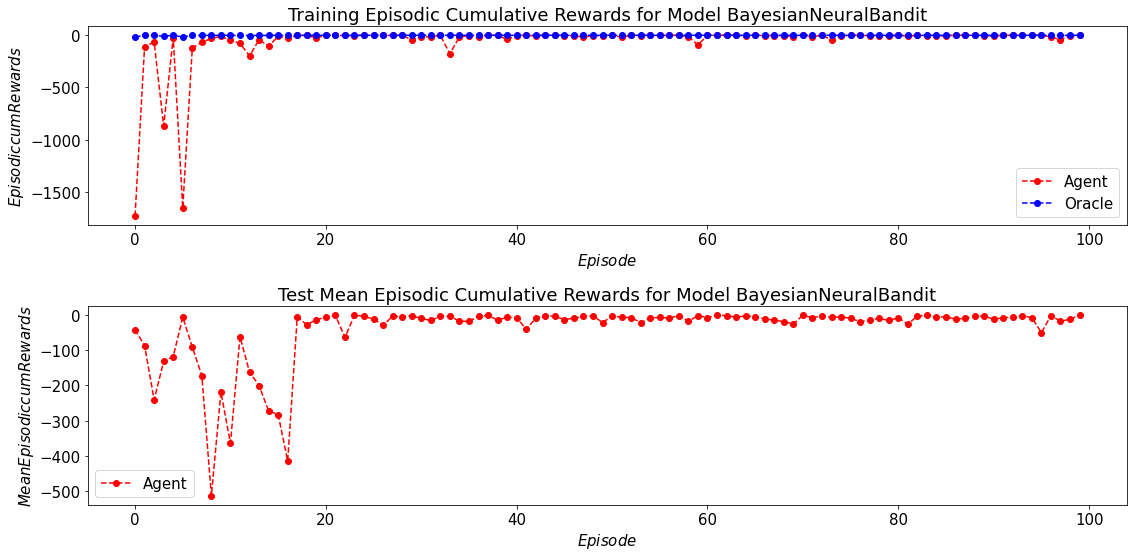

In [313]:
# viz training episodic cumulative rewards
plt.subplot(211)
plt.plot(range(num_episodes), 
         train_episodic_cumRewards_bayesianNeural_best, 
         linestyle='--', 
         marker='o', 
         color='r', 
         label='Agent')
plt.plot(range(num_episodes), 
         oracle_episodic_cumRewards_bayesianNeural_best, 
         linestyle='--', 
         marker='o', 
         color='b', 
         label='Oracle')

plt.legend()
plt.xlabel("$Episode$")
plt.ylabel("$Episodic cumRewards$")
plt.title(
    f"Training Episodic Cumulative Rewards for Model {hedgeBandit_bayesianNeural_best.__class__.__name__}"
)

# viz test episodic cumulative rewards
plt.subplot(212)
plt.plot(range(num_episodes), 
         test_episodic_cumRewards_bayesianNeural_best,
         linestyle='--', 
         marker='o', 
         color='r', 
         label='Agent')

plt.legend()
plt.xlabel("$Episode$")
plt.ylabel("$Mean Episodic cumRewards$")
plt.title(
    f"Test Mean Episodic Cumulative Rewards for Model {hedgeBandit_bayesianNeural_best.__class__.__name__}"
)


plt.tight_layout()
plt.show()

### Predict-Then-Optimize with SARIMAX

In [650]:
# initialization phase, to get data for forecast via random pulls
def first_five_days():
    p = 1
    lst = [p]
    
    for i in range(1,5):
        
        p += random.uniform(-1, 1)
        lst.append(p)
        
    return lst

In [651]:
# generate predicted stock prices
S_pred =[]
for episode in tqdm(range(S.shape[0])):
    
    S_pred_lst = first_five_days() # for day 1,..., 5

    for num_ob in range(5, 61):
        
        mod = sm.tsa.statespace.SARIMAX(S[episode][:num_ob], enforce_stationary=False)
        res = mod.fit(disp = False) # disp = False
        predict = res.get_prediction(start = num_ob, end = num_ob)

        S_pred_lst.append(predict.predicted_mean[0]) 
        
    S_pred.append(S_pred_lst)  
    
S_pred = np.array(S_pred)

  0%|          | 0/100 [00:00<?, ?it/s]

In [652]:
# generate call option prices from prediceted stock prices
C_pred = BSM(S_pred, K=1.0, r=0.01, sigma=0.3, T=60)

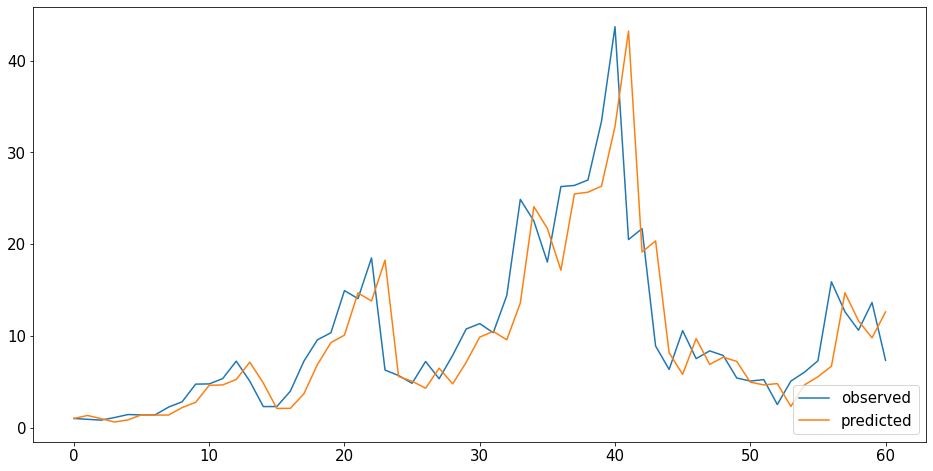

In [653]:
# viz one episode of observed stock prices v.s. predicted, display one-day lagging
fig, ax = plt.subplots()

ax.plot(np.arange(61), S[0], label='observed')
ax.plot(np.arange(61), S_pred[0], label='predicted')
legend = ax.legend(loc='lower right')

In [666]:
# create buffers
PTO1_episodic_rewards = []
PTO1_train_cumRewards = []
PTO1_oracle_cumRewards = []
PTO1_actions = []

# start training loop
for episode in tqdm(range(num_episodes)):
    
    # buffers
    actions = []
    actions_index = []
    rewards = []
    training_rewards = []
    oracle_rewards = []

    for t in range(T): # no action for last day
        train_rewards = []
        test_rewards = []
        
        for action in arms:
            num_stocks = action
            
            train_reward = 0.01* (C[episode][t] - C_pred[episode][t+1] + num_stocks * (S_pred[episode][t+1] - S[episode][t])   # Delta wealth
                                - 0.1 * S[episode][t] * np.abs(num_stocks if t == 0 else num_stocks - actions[t-1])) \
                                - np.var([   # V
                                            C[episode][i] - C[episode][i+1] + num_stocks * (S[episode][i+1] - S[episode][i]) \
                                            - 0.1 * S[episode][i] * np.abs(num_stocks if i == 0 else num_stocks - (actions+[action])[i-1])      
                                            for i in range(t+1) 
                                                if (i == t) or (action == actions[i])
                                            ])
            

            train_reward *= 100   # scalar gauging
            train_reward = np.min((train_reward, 2))   # reward cut-off           
            
            
            test_reward = 0.01* (C[episode][t] - C[episode][t+1] + num_stocks * (S[episode][t+1] - S[episode][t])   # Delta wealth
                            - 0.1 * S[episode][t] * np.abs(num_stocks if t == 0 else num_stocks - actions[t-1])) \
                            - np.var([   # V
                                        C[episode][i] - C[episode][i+1] + num_stocks * (S[episode][i+1] - S[episode][i]) \
                                        - 0.1 * S[episode][i] * np.abs(num_stocks if i == 0 else num_stocks - (actions + [action])[i-1])        
                                        for i in range(t+1) 
                                            if (i == t) or (action == actions[i])
                                    ])
            test_reward *= 100   # scalar gauging
            test_reward = np.min((test_reward, 2))   # reward cut-off
            

            train_rewards.append(train_reward)
            test_rewards.append(test_reward)
                  
        
        actions.append(arms[np.argmax(train_rewards, axis = 0)])
        actions_index.append(np.argmax(train_rewards, axis = 0))
        rewards.append(test_rewards[np.argmax(train_rewards, axis = 0)])    
        training_rewards.append(np.max(train_rewards, axis = 0))
        oracle_rewards.append(np.max(test_rewards, axis = 0))
        
        
    PTO1_episodic_rewards.append(rewards)
    PTO1_train_cumRewards.append(training_rewards)
    PTO1_oracle_cumRewards.append(oracle_rewards)
    PTO1_actions.append(actions_index)

  0%|          | 0/100 [00:00<?, ?it/s]

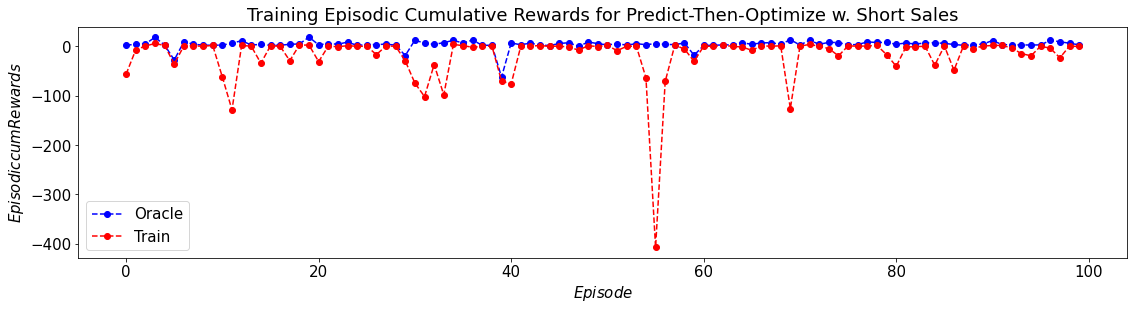

In [689]:
# viz training episodic cumulative rewards
plt.subplot(211)

plt.plot(range(len(PTO1_oracle_cumRewards)), 
         [sum(i) for i in PTO1_oracle_cumRewards], 
         linestyle='--', 
         marker='o', 
         color='b', 
         label='Oracle')

plt.plot(range(len(PTO1_episodic_rewards)), 
         [sum(i) for i in PTO1_episodic_rewards], 
         linestyle='--', 
         marker='o', 
         color='r', 
         label='Train')


plt.legend()
plt.xlabel("$Episode$")
plt.ylabel("$Episodic cumRewards$")
plt.title(
    f"Training Episodic Cumulative Rewards for Predict-Then-Optimize w. Short Sales"
)

plt.tight_layout()
plt.show()

## Continued Discussion

### Mean Stepwise Reward in Training Process

In [328]:
# compute mean reward at each training step for the best BayesianNeuralBandit
hedgeBandit_bayesianNeural_best_rewards = hedgeBandit_bayesianNeural_best.data.rewards.copy()
hedgeBandit_bayesianNeural_best_rewards = np.sum(hedgeBandit_bayesianNeural_best_rewards, axis=1)
hedgeBandit_bayesianNeural_best_rewards = hedgeBandit_bayesianNeural_best_rewards.reshape(-1,60)

In [495]:
# compute mean reward at each training step for NeuralGreedyBandit
hedgeBandit_neuralGreedy_rewards = hedgeBandit_neuralGreedy.data.rewards.copy()
hedgeBandit_neuralGreedy_rewards = np.sum(hedgeBandit_neuralGreedy_rewards, axis=1)
hedgeBandit_neuralGreedy_rewards = hedgeBandit_neuralGreedy_rewards.reshape(-1,60)

In [496]:
# compute mean reward at each training step for NaiveBandit
hedgeBandit_naiveBandit_rewards = hedgeBandit_naiveBandit.data.rewards.copy()
hedgeBandit_naiveBandit_rewards = np.sum(hedgeBandit_naiveBandit_rewards, axis=1)
hedgeBandit_naiveBandit_rewards = hedgeBandit_naiveBandit_rewards.reshape(-1,60)

In [540]:
# compute mean reward at each training step for RandomBandit
hedgeBandit_randomBandit_rewards = hedgeBandit_randomBandit.data.rewards.copy()
hedgeBandit_randomBandit_rewards = np.sum(hedgeBandit_randomBandit_rewards, axis=1)
hedgeBandit_randomBandit_rewards = hedgeBandit_randomBandit_rewards.reshape(-1,60)

In [668]:
# compute mean reward at each training step for SARIMAX
hedgeAgent_SARIMAX_rewards = np.array(PTO1_episodic_rewards)

In [361]:
## recover Oracle's setpwise reward from actions
# create reward buffer
oracle_stepwiseRewards_bayesianNeural_best = np.empty((num_episodes, T))

# for each epsisode
for episode in range(num_episodes):

    # get episodic test data
    stockPrice, optionPrice = S[episode], C[episode]
    
    # for each step
    for t in range(T):
        context = (stockPrice[t], T-t)   # stockPrice_t, ttm (time to maturity)
        action = oracle_actions_bayesianNeural_best[episode,t]
        
        num_stocks = arms[action]
        reward = 0.01 * (optionPrice[t] - optionPrice[t+1] + num_stocks * (stockPrice[t+1] - stockPrice[t])   # Delta wealth
                 - 0.1 * stockPrice[t] * np.abs(num_stocks if t == 0 else num_stocks - arms[oracle_actions_bayesianNeural_best[episode,t-1]])) \
                 - np.var([   # V approximation
                    optionPrice[i] - optionPrice[i+1] + num_stocks * (stockPrice[i+1] - stockPrice[i]) \
                    - 0.1 * stockPrice[i] * np.abs(num_stocks if i == 0 else num_stocks - arms[oracle_actions_bayesianNeural_best[episode,i-1]])       
                    for i in range(t+1) 
                        if (i == t) or ((action == oracle_actions_bayesianNeural_best[episode,i]) and all(np.array(context[:]) == hedgeBandit_bayesianNeural_best.data.contexts[episode * T + i]))   
                    ])
        reward *= 100   # scalar gauging factor
        reward = np.min((reward, 2))   # reward cut-off
        
        # update to buffer
        oracle_stepwiseRewards_bayesianNeural_best[episode,t] = reward

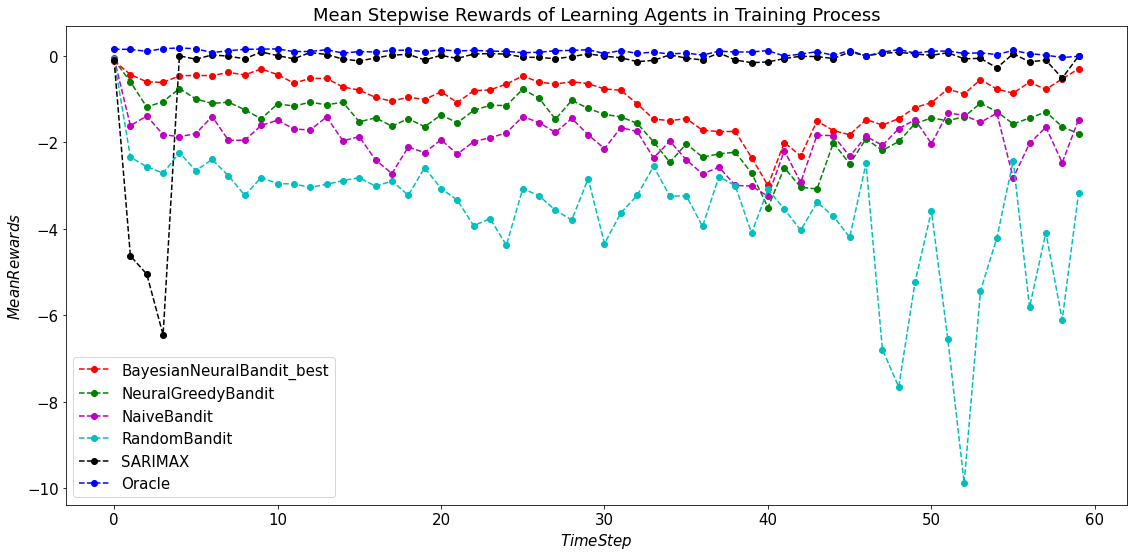

In [670]:
# viz mean reward at each training step for the learning agents
plt.plot(range(T), 
         np.mean(hedgeBandit_bayesianNeural_best_rewards, axis=0), 
         linestyle='--', 
         marker='o', 
         color='r', 
         label='BayesianNeuralBandit_best')
plt.plot(range(T), 
         np.mean(hedgeBandit_neuralGreedy_rewards, axis=0), 
         linestyle='--', 
         marker='o', 
         color='g', 
         label='NeuralGreedyBandit')
plt.plot(range(T), 
         np.mean(hedgeBandit_naiveBandit_rewards, axis=0), 
         linestyle='--', 
         marker='o', 
         color='m', 
         label='NaiveBandit')
plt.plot(range(T), 
         np.mean(hedgeBandit_randomBandit_rewards, axis=0), 
         linestyle='--', 
         marker='o', 
         color='c', 
         label='RandomBandit')
plt.plot(range(T), 
         np.mean(hedgeAgent_SARIMAX_rewards, axis=0), 
         linestyle='--', 
         marker='o', 
         color='k', 
         label='SARIMAX')
plt.plot(range(T), 
         np.mean(oracle_stepwiseRewards_bayesianNeural_best, axis=0), 
         linestyle='--', 
         marker='o', 
         color='b', 
         label='Oracle')

plt.legend()
plt.xlabel("$Time Step$")
plt.ylabel("$Mean Rewards$")
plt.title(
    f"Mean Stepwise Rewards of Learning Agents in Training Process"
)

plt.tight_layout()
plt.show()

### Decision Distributions against Oracle

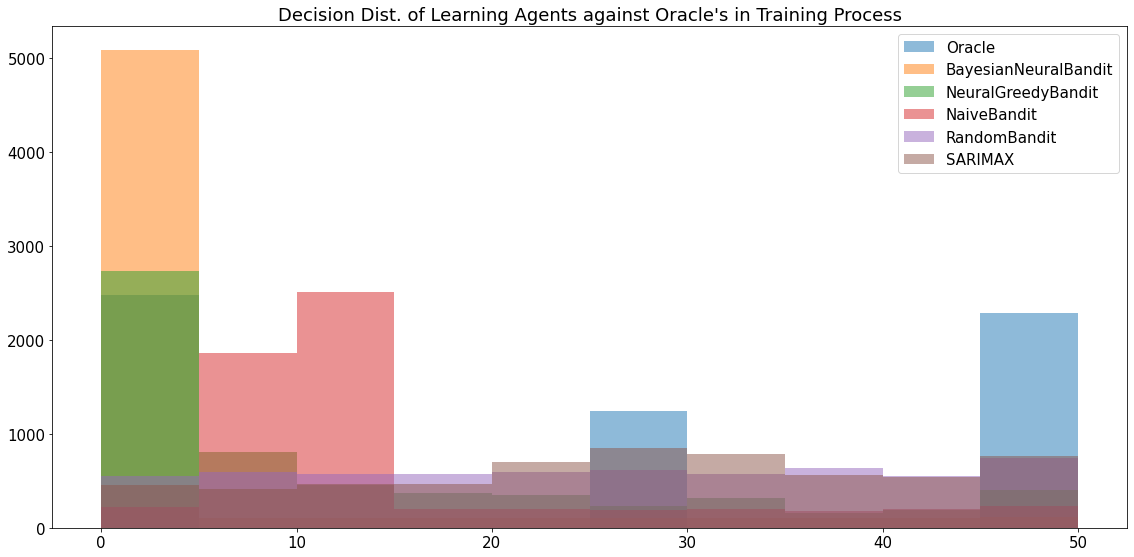

In [683]:
# viz decision distributions of each agent during training against Oracle's
plt.hist(oracle_actions_bayesianNeural_best.flatten(), alpha=0.5, label='Oracle')
plt.hist(hedgeBandit_bayesianNeural_best.data.actions, alpha=0.5, label='BayesianNeuralBandit')
plt.hist(hedgeBandit_neuralGreedy.data.actions, alpha=0.5, label='NeuralGreedyBandit')
plt.hist(hedgeBandit_naiveBandit.data.actions, alpha=0.5, label='NaiveBandit')
plt.hist(hedgeBandit_randomBandit.data.actions, alpha=0.5, label='RandomBandit')
plt.hist(np.array(PTO1_actions).flatten(), alpha=0.5, label='SARIMAX')

plt.title("Decision Dist. of Learning Agents against Oracle's in Training Process")
plt.legend()
plt.tight_layout()
plt.show()

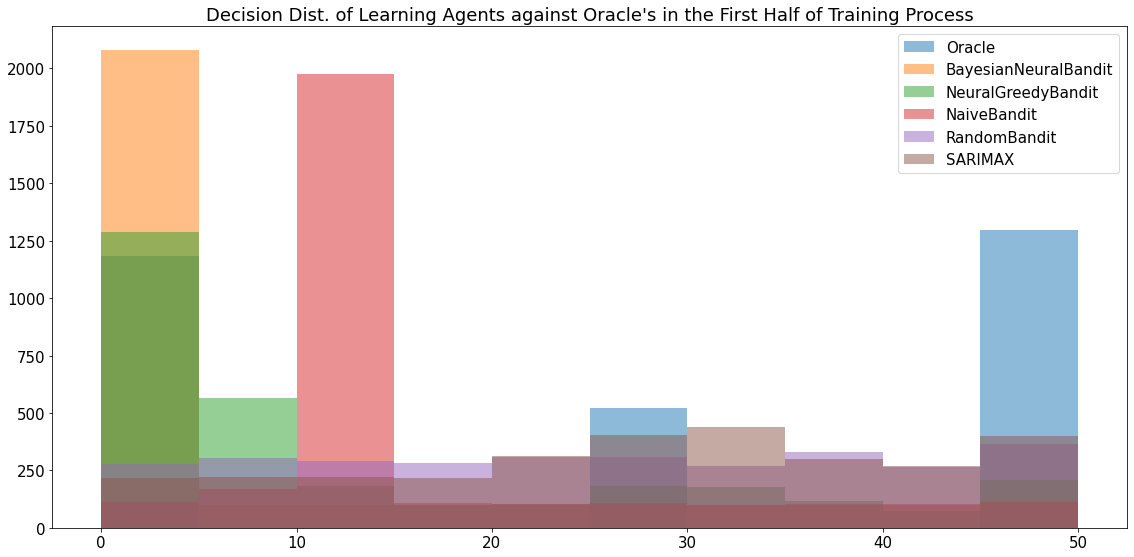

In [679]:
# viz decision distributions of each agent during training against Oracle's in first half
plt.hist(oracle_actions_bayesianNeural_best.flatten()[:3000], alpha=0.5, label='Oracle')
plt.hist(hedgeBandit_bayesianNeural_best.data.actions[:3000], alpha=0.5, label='BayesianNeuralBandit')
plt.hist(hedgeBandit_neuralGreedy.data.actions[:3000], alpha=0.5, label='NeuralGreedyBandit')
plt.hist(hedgeBandit_naiveBandit.data.actions[:3000], alpha=0.5, label='NaiveBandit')
plt.hist(hedgeBandit_randomBandit.data.actions[:3000], alpha=0.5, label='RandomBandit')
plt.hist(np.array(PTO1_actions).flatten()[:3000], alpha=0.5, label='SARIMAX')

plt.title("Decision Dist. of Learning Agents against Oracle's in the First Half of Training Process")
plt.legend()
plt.tight_layout()
plt.show()

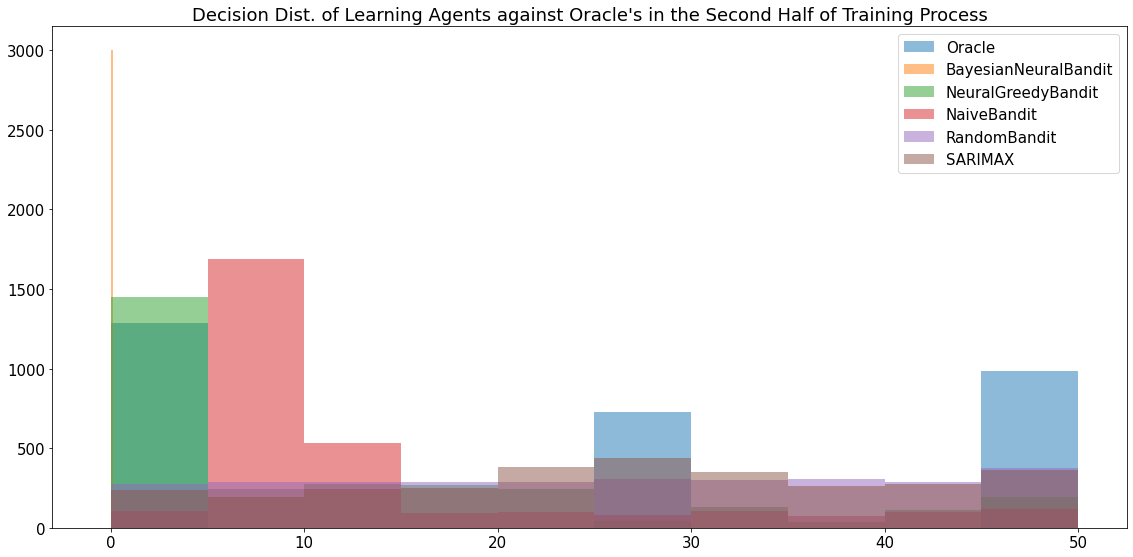

In [678]:
# viz decision distributions of each agent during training against Oracle's in second half
plt.hist(oracle_actions_bayesianNeural_best.flatten()[3000:], alpha=0.5, label='Oracle')
plt.hist(hedgeBandit_bayesianNeural_best.data.actions[3000:], alpha=0.5, label='BayesianNeuralBandit')
plt.hist(hedgeBandit_neuralGreedy.data.actions[3000:], alpha=0.5, label='NeuralGreedyBandit')
plt.hist(hedgeBandit_naiveBandit.data.actions[3000:], alpha=0.5, label='NaiveBandit')
plt.hist(hedgeBandit_randomBandit.data.actions[3000:], alpha=0.5, label='RandomBandit')
plt.hist(np.array(PTO1_actions).flatten()[3000:], alpha=0.5, label='SARIMAX')

plt.title("Decision Dist. of Learning Agents against Oracle's in the Second Half of Training Process")
plt.legend()
plt.tight_layout()
plt.show()

----------------------------------------------------------------------------------------  End  ---------------------------------------------------------------------------------------------------

# Appendix

In [ ]:
# context representations extractor
representaions = {}
def get_repr(name):
    def hook(model, input, output):
        representaions[name] = output.detach()
    return hook
net[-3].register_forward_hook(get_repr("context_repr_from_last_hidden_layer"))

In [ ]:
### Alternative trainer and test algo. to the above implementation. These actually converge faster.
## define common train func.
# given model variation, some args, e.g. the neural network, still need mannual config.
def trainBandit(model_cls, num_episodes, T, S, C, test_func, **kwargs):
    """Construct-trains a bandit with model-specific input arguments, and return training/test episodic cumulative rewards."""
    
    # construct model with specified args.
    model = model_cls(**kwargs)
    
    # create Oracle's action and reward buffers
    oracle_actions = []
    oracle_rewards = []
    
    # create episodic reward buffers
    train_episodic_cumRewards = np.empty(num_episodes)
    test_episodic_cumRewards = np.empty(num_episodes)
    
    # start training for each episode
    for episode, (stockPrice, optionPrice) in enumerate(zip(S,C)):

        # for each step
        for t in range(T):
            
            # let agent work
            context = (stockPrice[t], T-t)   # stockPrice_t, ttm (time to maturity)

            action = model.action(context)

            num_stocks = arms[action]
            reward = 0.01* (optionPrice[t] - optionPrice[t+1] + num_stocks * (stockPrice[t+1] - stockPrice[t])   # Delta wealth
                     - 0.1 * stockPrice[t] * np.abs(num_stocks if t == 0 else num_stocks - model.data.actions[-1])) \
                     - np.var([   # V approximation
                        optionPrice[i] - optionPrice[i+1] + num_stocks * (stockPrice[i+1] - stockPrice[i]) \
                        - 0.1 * stockPrice[i] * np.abs(num_stocks if i == 0 else num_stocks - arms[(model.data.actions + [action])[i-1]])       
                        for i in range(t+1) 
                            if i == t or (action == model.data.actions[i] and all(np.array(context[:]) == model.data.contexts[i]))
                        ])
            reward *= 100   # scalar gauging
            reward = np.min((reward, 2))   # reward cut-off

            model.update(context, action, reward)
            
            # compute Oracle's action and reward at each step
            true_actions_rewards = [
                0.01* (optionPrice[t] - optionPrice[t+1] + num_stocks * (stockPrice[t+1] - stockPrice[t])   # Delta wealth
                     - 0.1 * stockPrice[t] * np.abs(num_stocks if t == 0 else num_stocks - model.data.actions[-1])) \
                     - np.var([   # V approximation
                        optionPrice[i] - optionPrice[i+1] + num_stocks * (stockPrice[i+1] - stockPrice[i]) \
                        - 0.1 * stockPrice[i] * np.abs(num_stocks if i == 0 else num_stocks - arms[(model.data.actions + [action])[i-1]])       
                        for i in range(t+1) 
                            if i == t or (action == model.data.actions[i] and all(np.array(context[:]) == model.data.contexts[i]))
                        ])
                for num_stocks in arms
            ]
            oracle_actions.append(np.argmax(true_actions_rewards))
            oracle_rewards.append(np.max(true_actions_rewards))
        
        # compute episodic cumReward at the end of each training episode
        reward_train = np.sum(model.data.rewards[episode*60:])
        train_episodic_cumRewards[episode] = reward_train
        
        # test performance at the end of each episode
        reward_test = test_func(model)
        test_episodic_cumRewards[episode] = reward_test
        print(f"{model.__class__.__name__} | End of Episode: {episode}, Train Episodic cumReward: {reward_train}, Test Mean Episodic cumReward: {reward_test}")   
    
    # reduce Oracle's training performance statistics
    oracle_actions = np.array(oracle_actions).reshape(-1, T)
    oracle_rewards = np.array(oracle_rewards).reshape(-1, T)
    oracle_episodic_cumRewards = np.sum(oracle_rewards, axis=1)
    
    return model, train_episodic_cumRewards, test_episodic_cumRewards, oracle_episodic_cumRewards, oracle_actions

# def performance-test func.
def testBandit(model, num_episodes=10, T=60):
    """Tests bandit performance, and returns mean episodic cumulative reward."""
    
    # generate test data and create reward buffer
    S, C = dataGen(num_episodes, T=T)
    rewards = []
    
    # for each epsisode
    for episode in range(num_episodes):
        
        # get episodic test data
        stockPrice, optionPrice = S[episode], C[episode]
        
        # for each step
        for t in range(T):
            
            context = (stockPrice[t], T-t)   # stockPrice_t, ttm (time to maturity)
        
            action = model.predict(context)   # choose best action in prediction mode

            num_stocks = arms[action]
            reward = 0.01 * (optionPrice[t] - optionPrice[t+1] + num_stocks * (stockPrice[t+1] - stockPrice[t])   # Delta wealth
                     - 0.1 * stockPrice[t] * np.abs(num_stocks if t == 0 else num_stocks - model.data.actions[-1])) \
                     - np.var([   # V
                        optionPrice[i] - optionPrice[i+1] + num_stocks * (stockPrice[i+1] - stockPrice[i]) \
                        - 0.1 * stockPrice[i] * np.abs(num_stocks if i == 0 else num_stocks - arms[(model.data.actions + [action])[i-1]])       
                        for i in range(t+1) 
                            if i == t or (action == model.data.actions[i] and all(np.array(context[:]) == model.data.contexts[i]))
                        ])
            reward *= 100   # scalar gauging factor
            reward = np.min((reward, 2))   # reward cut-off
            rewards.append(reward)
        
    return np.mean(rewards) * T

In [ ]:
### Yet another alternative trainer and test algo. to the above implementation. These actually converge faster.
## define common train func.
# given model variation, some args, e.g. the neural network, still need mannual config.
def trainBandit(model_cls, num_episodes, T, S, C, test_func, **kwargs):
    """Construct-trains a bandit with model-specific input arguments, and return training/test episodic cumulative rewards."""
    
    # construct model with specified args.
    model = model_cls(**kwargs)
    
    # create Oracle's action and reward buffers
    oracle_actions = []
    oracle_rewards = []
    
    # create episodic reward buffers
    train_episodic_cumRewards = np.empty(num_episodes)
    test_episodic_cumRewards = np.empty(num_episodes)
    
    # start training for each episode
    for episode, (stockPrice, optionPrice) in enumerate(zip(S,C)):

        # for each step
        for t in range(T):
            
            # let agent work
            context = (stockPrice[t], T-t)   # stockPrice_t, ttm (time to maturity)

            action = model.action(context)

            num_stocks = arms[action]
            reward = optionPrice[t] - optionPrice[t+1] + num_stocks * (stockPrice[t+1] - stockPrice[t]) \
                     - 0.1 * stockPrice[t] * np.abs(num_stocks if t == 0 else num_stocks - arms[model.data.actions[-1]])   # Delta wealth
            reward = 0.01 * reward - reward ** 2
            #reward *= 100   # scalar gauging
            #reward = np.min((reward, 2))   # reward cut-off

            model.update(context, action, reward)
            
            # compute Oracle's action and reward at each step
            true_actions_rewards = [
                0.01 * (optionPrice[t] - optionPrice[t+1] + arms[action] * (stockPrice[t+1] - stockPrice[t])   # Delta wealth
                - 0.1 * stockPrice[t] * np.abs(arms[action] if t == 0 else arms[action] - arms[oracle_actions[-1]]))
                - (optionPrice[t] - optionPrice[t+1] + arms[action] * (stockPrice[t+1] - stockPrice[t])   # Delta wealth
                - 0.1 * stockPrice[t] * np.abs(arms[action] if t == 0 else arms[action] - arms[oracle_actions[-1]])) ** 2
                for action in range(model.num_actions)
            ]
            
            oracle_actions.append(np.argmax(true_actions_rewards))
            oracle_rewards.append(np.max(true_actions_rewards))
        
        # compute episodic cumReward at the end of each training episode
        reward_train = np.sum(model.data.rewards[episode*60:])
        train_episodic_cumRewards[episode] = reward_train
        
        # test performance at the end of each episode
        reward_test = test_func(model)
        test_episodic_cumRewards[episode] = reward_test
        print(f"{model.__class__.__name__} | End of Episode: {episode}, Train Episodic cumReward: {reward_train}, Test Mean Episodic cumReward: {reward_test}")   
    
    # reduce Oracle's training performance statistics
    oracle_actions = np.array(oracle_actions).reshape(-1, T)
    oracle_rewards = np.array(oracle_rewards).reshape(-1, T)
    oracle_episodic_cumRewards = np.sum(oracle_rewards, axis=1)
    
    return model, train_episodic_cumRewards, test_episodic_cumRewards, oracle_episodic_cumRewards, oracle_actions

# def performance-test func.
def testBandit(model, num_episodes=10, T=60):
    """Tests bandit performance, and returns mean episodic cumulative reward."""
    
    # generate test data, create context, action and reward buffer
    S, C = dataGen(num_episodes, T=T)
    contexts = [] 
    actions = []
    rewards = []
    
    # for each epsisode
    for episode in range(num_episodes):
        
        # get episodic test data
        stockPrice, optionPrice = S[episode], C[episode]
        
        # for each step
        for t in range(T):
            
            context = (stockPrice[t], T-t)   # stockPrice_t, ttm (time to maturity)
        
            action = model.predict(context)   # choose best action in prediction mode

            num_stocks = arms[action]
            reward = optionPrice[t] - optionPrice[t+1] + num_stocks * (stockPrice[t+1] - stockPrice[t]) \
                     - 0.1 * stockPrice[t] * np.abs(num_stocks if t == 0 else num_stocks - arms[actions[-1]])   # Delta wealth
            reward = 0.01 * reward - reward ** 2
            #reward *= 100   # scalar gauging factor
            #reward = np.min((reward, 2))   # reward cut-off
            rewards.append(reward)
            
            # update buffers
            contexts.append(context)
            actions.append(action)
        
    return np.mean(rewards) * T